### Cab-Driver Agent

In [21]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [22]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print("\nData shape:\n", np.shape(Time_matrix))
print("dimensions = ",len(Time_matrix.shape))


Data shape:
 (5, 5, 24, 7)
dimensions =  4


In [23]:
 # Call the environment
env = CabDriver()

#### Tracking the state-action pairs for checking convergence


In [24]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [25]:
class DQNAgent:
    def __init__(self, state_size, action_size,learning_rate):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        #self.discount_factor =0.9
        self.discount_factor =0.95

        #self.learning_rate =0.001
        #self.learning_rate = 0.01
        self.learning_rate = learning_rate

        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay =  .995
        #self.epsilon_decay = -0.0005
        self.epsilon_decay =  .999
        #self.epsilon_min = 0.001
        self.epsilon_min = 0.00001

        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [26]:
Episodes = 5000

### DQN block

In [27]:
#Under Test
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [3, 17, 1]
episode 0, reward -44.0, memory_length 129, epsilon 0.999, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 1, reward -411.0, memory_length 263, epsilon 0.998001, time 737.0, rides 133
Initial State is  [3, 17, 1]
episode 2, reward -101.0, memory_length 391, epsilon 0.997002999, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 3, reward -366.0, memory_length 521, epsilon 0.996005996001, time 728.0, rides 129
Initial State is  [3, 17, 1]
episode 4, reward -411.0, memory_length 649, epsilon 0.995009990004999, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 5, reward -65.0, memory_length 779, epsilon 0.994014980014994, time 728.0, rides 129
Initial State is  [3, 17, 1]
episode 6, reward -66.0, memory_length 927, epsilon 0.993020965034979, time 729.0, rides 147
Initial State is  [3, 17, 1]
episode 7, reward -222.0, memory_length 1059, epsilon 0.9920279440699441, time 731.0, rides 131
Initial State is  [3, 17, 1]
episode 8, reward 

episode 66, reward -47.0, memory_length 2000, epsilon 0.9351638519212846, time 735.0, rides 124
Initial State is  [3, 17, 1]
episode 67, reward -52.0, memory_length 2000, epsilon 0.9342286880693633, time 725.0, rides 130
Initial State is  [3, 17, 1]
episode 68, reward -144.0, memory_length 2000, epsilon 0.933294459381294, time 724.0, rides 111
Initial State is  [3, 17, 1]
episode 69, reward -417.0, memory_length 2000, epsilon 0.9323611649219127, time 727.0, rides 132
Initial State is  [3, 17, 1]
episode 70, reward -220.0, memory_length 2000, epsilon 0.9314288037569908, time 733.0, rides 126
Initial State is  [3, 17, 1]
episode 71, reward -145.0, memory_length 2000, epsilon 0.9304973749532338, time 730.0, rides 134
Initial State is  [3, 17, 1]
episode 72, reward -230.0, memory_length 2000, epsilon 0.9295668775782806, time 738.0, rides 124
Initial State is  [3, 17, 1]
episode 73, reward -326.0, memory_length 2000, epsilon 0.9286373107007023, time 723.0, rides 123
Initial State is  [3, 17

episode 132, reward -43.0, memory_length 2000, epsilon 0.8754068367770318, time 732.0, rides 115
Initial State is  [3, 17, 1]
episode 133, reward -102.0, memory_length 2000, epsilon 0.8745314299402548, time 723.0, rides 122
Initial State is  [3, 17, 1]
episode 134, reward -259.0, memory_length 2000, epsilon 0.8736568985103146, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 135, reward -229.0, memory_length 2000, epsilon 0.8727832416118043, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 136, reward -49.0, memory_length 2000, epsilon 0.8719104583701925, time 731.0, rides 116
Initial State is  [3, 17, 1]
episode 137, reward -71.0, memory_length 2000, epsilon 0.8710385479118223, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 138, reward -263.0, memory_length 2000, epsilon 0.8701675093639105, time 724.0, rides 128
Initial State is  [3, 17, 1]
episode 139, reward -40.0, memory_length 2000, epsilon 0.8692973418545467, time 727.0, rides 121
Initial State is 

episode 197, reward -25.0, memory_length 2000, epsilon 0.8202885863627752, time 733.0, rides 129
Initial State is  [3, 17, 1]
episode 198, reward -338.0, memory_length 2000, epsilon 0.8194682977764125, time 735.0, rides 134
Initial State is  [3, 17, 1]
episode 199, reward -15.0, memory_length 2000, epsilon 0.818648829478636, time 722.0, rides 111
Initial State is  [3, 17, 1]
episode 200, reward -355.0, memory_length 2000, epsilon 0.8178301806491574, time 733.0, rides 133
Initial State is  [3, 17, 1]
episode 201, reward -5.0, memory_length 2000, epsilon 0.8170123504685082, time 735.0, rides 120
Initial State is  [3, 17, 1]
episode 202, reward -197.0, memory_length 2000, epsilon 0.8161953381180397, time 733.0, rides 124
Initial State is  [3, 17, 1]
episode 203, reward -9.0, memory_length 2000, epsilon 0.8153791427799216, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 204, reward -18.0, memory_length 2000, epsilon 0.8145637636371417, time 731.0, rides 127
Initial State is  [3,

episode 262, reward -79.0, memory_length 2000, epsilon 0.7686407469632577, time 733.0, rides 131
Initial State is  [3, 17, 1]
episode 263, reward 16.0, memory_length 2000, epsilon 0.7678721062162944, time 727.0, rides 137
Initial State is  [3, 17, 1]
episode 264, reward 88.0, memory_length 2000, epsilon 0.7671042341100781, time 723.0, rides 141
Initial State is  [3, 17, 1]
episode 265, reward -216.0, memory_length 2000, epsilon 0.766337129875968, time 735.0, rides 125
Initial State is  [3, 17, 1]
episode 266, reward 71.0, memory_length 2000, epsilon 0.7655707927460921, time 729.0, rides 113
Initial State is  [3, 17, 1]
episode 267, reward -132.0, memory_length 2000, epsilon 0.764805221953346, time 726.0, rides 132
Initial State is  [3, 17, 1]
episode 268, reward -219.0, memory_length 2000, epsilon 0.7640404167313927, time 731.0, rides 131
Initial State is  [3, 17, 1]
episode 269, reward 5.0, memory_length 2000, epsilon 0.7632763763146613, time 730.0, rides 127
Initial State is  [3, 17,

episode 328, reward -50.0, memory_length 2000, epsilon 0.7195245662400531, time 725.0, rides 125
Initial State is  [3, 17, 1]
episode 329, reward 171.0, memory_length 2000, epsilon 0.7188050416738131, time 726.0, rides 134
Initial State is  [3, 17, 1]
episode 330, reward -56.0, memory_length 2000, epsilon 0.7180862366321393, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 331, reward 29.0, memory_length 2000, epsilon 0.7173681503955072, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 332, reward 167.0, memory_length 2000, epsilon 0.7166507822451117, time 726.0, rides 135
Initial State is  [3, 17, 1]
episode 333, reward -73.0, memory_length 2000, epsilon 0.7159341314628666, time 725.0, rides 114
Initial State is  [3, 17, 1]
episode 334, reward -226.0, memory_length 2000, epsilon 0.7152181973314037, time 729.0, rides 125
Initial State is  [3, 17, 1]
episode 335, reward -90.0, memory_length 2000, epsilon 0.7145029791340722, time 729.0, rides 135
Initial State is  [3,

episode 394, reward 245.0, memory_length 2000, epsilon 0.6735469118288684, time 735.0, rides 121
Initial State is  [3, 17, 1]
episode 395, reward 117.0, memory_length 2000, epsilon 0.6728733649170395, time 721.0, rides 120
Initial State is  [3, 17, 1]
episode 396, reward -48.0, memory_length 2000, epsilon 0.6722004915521225, time 729.0, rides 136
Initial State is  [3, 17, 1]
episode 397, reward 212.0, memory_length 2000, epsilon 0.6715282910605703, time 735.0, rides 111
Initial State is  [3, 17, 1]
episode 398, reward 167.0, memory_length 2000, epsilon 0.6708567627695098, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 399, reward -73.0, memory_length 2000, epsilon 0.6701859060067403, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 400, reward 204.0, memory_length 2000, epsilon 0.6695157201007336, time 734.0, rides 128
Initial State is  [3, 17, 1]
episode 401, reward 140.0, memory_length 2000, epsilon 0.6688462043806328, time 724.0, rides 130
Initial State is  [3,

episode 460, reward 381.0, memory_length 2000, epsilon 0.6305072317473174, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 461, reward 130.0, memory_length 2000, epsilon 0.6298767245155701, time 734.0, rides 127
Initial State is  [3, 17, 1]
episode 462, reward 61.0, memory_length 2000, epsilon 0.6292468477910546, time 727.0, rides 124
Initial State is  [3, 17, 1]
episode 463, reward 107.0, memory_length 2000, epsilon 0.6286176009432635, time 728.0, rides 126
Initial State is  [3, 17, 1]
episode 464, reward 55.0, memory_length 2000, epsilon 0.6279889833423202, time 727.0, rides 121
Initial State is  [3, 17, 1]
episode 465, reward 150.0, memory_length 2000, epsilon 0.6273609943589779, time 739.0, rides 130
Initial State is  [3, 17, 1]
episode 466, reward 177.0, memory_length 2000, epsilon 0.6267336333646188, time 734.0, rides 123
Initial State is  [3, 17, 1]
episode 467, reward 157.0, memory_length 2000, epsilon 0.6261068997312542, time 736.0, rides 126
Initial State is  [3, 1

episode 526, reward 189.0, memory_length 2000, epsilon 0.5902177892943418, time 734.0, rides 142
Initial State is  [3, 17, 1]
episode 527, reward 234.0, memory_length 2000, epsilon 0.5896275715050474, time 730.0, rides 126
Initial State is  [3, 17, 1]
episode 528, reward 88.0, memory_length 2000, epsilon 0.5890379439335424, time 729.0, rides 132
Initial State is  [3, 17, 1]
episode 529, reward 213.0, memory_length 2000, epsilon 0.5884489059896089, time 724.0, rides 141
Initial State is  [3, 17, 1]
episode 530, reward 63.0, memory_length 2000, epsilon 0.5878604570836192, time 735.0, rides 127
Initial State is  [3, 17, 1]
episode 531, reward -73.0, memory_length 2000, epsilon 0.5872725966265356, time 735.0, rides 124
Initial State is  [3, 17, 1]
episode 532, reward 145.0, memory_length 2000, epsilon 0.5866853240299091, time 729.0, rides 119
Initial State is  [3, 17, 1]
episode 533, reward -174.0, memory_length 2000, epsilon 0.5860986387058792, time 734.0, rides 133
Initial State is  [3, 

episode 592, reward 274.0, memory_length 2000, epsilon 0.5525028441531146, time 734.0, rides 131
Initial State is  [3, 17, 1]
episode 593, reward 140.0, memory_length 2000, epsilon 0.5519503413089615, time 722.0, rides 118
Initial State is  [3, 17, 1]
episode 594, reward 118.0, memory_length 2000, epsilon 0.5513983909676525, time 724.0, rides 126
Initial State is  [3, 17, 1]
episode 595, reward 203.0, memory_length 2000, epsilon 0.5508469925766849, time 729.0, rides 139
Initial State is  [3, 17, 1]
episode 596, reward 102.0, memory_length 2000, epsilon 0.5502961455841082, time 735.0, rides 111
Initial State is  [3, 17, 1]
episode 597, reward 381.0, memory_length 2000, epsilon 0.5497458494385241, time 729.0, rides 115
Initial State is  [3, 17, 1]
episode 598, reward 210.0, memory_length 2000, epsilon 0.5491961035890855, time 732.0, rides 131
Initial State is  [3, 17, 1]
episode 599, reward 237.0, memory_length 2000, epsilon 0.5486469074854965, time 731.0, rides 120
Initial State is  [3,

episode 658, reward 201.0, memory_length 2000, epsilon 0.5171978858215134, time 734.0, rides 126
Initial State is  [3, 17, 1]
episode 659, reward 248.0, memory_length 2000, epsilon 0.5166806879356919, time 737.0, rides 132
Initial State is  [3, 17, 1]
episode 660, reward 168.0, memory_length 2000, epsilon 0.5161640072477562, time 727.0, rides 134
Initial State is  [3, 17, 1]
episode 661, reward -227.0, memory_length 2000, epsilon 0.5156478432405085, time 735.0, rides 116
Initial State is  [3, 17, 1]
episode 662, reward 460.0, memory_length 2000, epsilon 0.515132195397268, time 725.0, rides 122
Initial State is  [3, 17, 1]
episode 663, reward 286.0, memory_length 2000, epsilon 0.5146170632018707, time 738.0, rides 132
Initial State is  [3, 17, 1]
episode 664, reward -132.0, memory_length 2000, epsilon 0.5141024461386688, time 725.0, rides 131
Initial State is  [3, 17, 1]
episode 665, reward 224.0, memory_length 2000, epsilon 0.5135883436925301, time 724.0, rides 140
Initial State is  [3

episode 723, reward 42.0, memory_length 2000, epsilon 0.4846335495759935, time 728.0, rides 124
Initial State is  [3, 17, 1]
episode 724, reward 295.0, memory_length 2000, epsilon 0.4841489160264175, time 729.0, rides 131
Initial State is  [3, 17, 1]
episode 725, reward 156.0, memory_length 2000, epsilon 0.4836647671103911, time 730.0, rides 142
Initial State is  [3, 17, 1]
episode 726, reward 338.0, memory_length 2000, epsilon 0.4831811023432807, time 725.0, rides 125
Initial State is  [3, 17, 1]
episode 727, reward 359.0, memory_length 2000, epsilon 0.4826979212409374, time 736.0, rides 138
Initial State is  [3, 17, 1]
episode 728, reward 393.0, memory_length 2000, epsilon 0.48221522331969646, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 729, reward 369.0, memory_length 2000, epsilon 0.48173300809637676, time 735.0, rides 132
Initial State is  [3, 17, 1]
episode 730, reward 295.0, memory_length 2000, epsilon 0.48125127508828036, time 734.0, rides 136
Initial State is  [

episode 788, reward 401.0, memory_length 2000, epsilon 0.4541195619962011, time 725.0, rides 128
Initial State is  [3, 17, 1]
episode 789, reward 275.0, memory_length 2000, epsilon 0.4536654424342049, time 736.0, rides 135
Initial State is  [3, 17, 1]
episode 790, reward 518.0, memory_length 2000, epsilon 0.45321177699177073, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 791, reward 546.0, memory_length 2000, epsilon 0.452758565214779, time 735.0, rides 124
Initial State is  [3, 17, 1]
episode 792, reward 380.0, memory_length 2000, epsilon 0.4523058066495642, time 730.0, rides 127
Initial State is  [3, 17, 1]
episode 793, reward 419.0, memory_length 2000, epsilon 0.45185350084291465, time 729.0, rides 113
Initial State is  [3, 17, 1]
episode 794, reward 116.0, memory_length 2000, epsilon 0.4514016473420717, time 730.0, rides 143
Initial State is  [3, 17, 1]
episode 795, reward 253.0, memory_length 2000, epsilon 0.45095024569472963, time 725.0, rides 116
Initial State is  [

episode 853, reward 298.0, memory_length 2000, epsilon 0.42552682695625954, time 734.0, rides 124
Initial State is  [3, 17, 1]
episode 854, reward 768.0, memory_length 2000, epsilon 0.4251013001293033, time 735.0, rides 137
Initial State is  [3, 17, 1]
episode 855, reward 493.0, memory_length 2000, epsilon 0.424676198829174, time 731.0, rides 123
Initial State is  [3, 17, 1]
episode 856, reward 205.0, memory_length 2000, epsilon 0.4242515226303448, time 725.0, rides 113
Initial State is  [3, 17, 1]
episode 857, reward 307.0, memory_length 2000, epsilon 0.42382727110771445, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 858, reward 505.0, memory_length 2000, epsilon 0.4234034438366067, time 722.0, rides 137
Initial State is  [3, 17, 1]
episode 859, reward 751.0, memory_length 2000, epsilon 0.4229800403927701, time 722.0, rides 126
Initial State is  [3, 17, 1]
episode 860, reward 213.0, memory_length 2000, epsilon 0.42255706035237733, time 726.0, rides 123
Initial State is  [

episode 918, reward 618.0, memory_length 2000, epsilon 0.3987343766111031, time 730.0, rides 134
Initial State is  [3, 17, 1]
episode 919, reward 295.0, memory_length 2000, epsilon 0.398335642234492, time 725.0, rides 116
Initial State is  [3, 17, 1]
episode 920, reward 437.0, memory_length 2000, epsilon 0.3979373065922575, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 921, reward 525.0, memory_length 2000, epsilon 0.39753936928566525, time 734.0, rides 132
Initial State is  [3, 17, 1]
episode 922, reward 572.0, memory_length 2000, epsilon 0.3971418299163796, time 723.0, rides 129
Initial State is  [3, 17, 1]
episode 923, reward 520.0, memory_length 2000, epsilon 0.3967446880864632, time 732.0, rides 113
Initial State is  [3, 17, 1]
episode 924, reward 771.0, memory_length 2000, epsilon 0.3963479433983767, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 925, reward 105.0, memory_length 2000, epsilon 0.3959515954549783, time 725.0, rides 125
Initial State is  [3,

episode 983, reward 670.0, memory_length 2000, epsilon 0.3736288596154426, time 730.0, rides 137
Initial State is  [3, 17, 1]
episode 984, reward 315.0, memory_length 2000, epsilon 0.37325523075582717, time 734.0, rides 132
Initial State is  [3, 17, 1]
episode 985, reward 437.0, memory_length 2000, epsilon 0.37288197552507135, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 986, reward 454.0, memory_length 2000, epsilon 0.37250909354954626, time 730.0, rides 119
Initial State is  [3, 17, 1]
episode 987, reward 424.0, memory_length 2000, epsilon 0.37213658445599673, time 723.0, rides 118
Initial State is  [3, 17, 1]
episode 988, reward 589.0, memory_length 2000, epsilon 0.3717644478715407, time 723.0, rides 123
Initial State is  [3, 17, 1]
episode 989, reward 281.0, memory_length 2000, epsilon 0.3713926834236692, time 727.0, rides 128
Initial State is  [3, 17, 1]
episode 990, reward 470.0, memory_length 2000, epsilon 0.37102129074024554, time 724.0, rides 128
Initial State is

episode 1048, reward 329.0, memory_length 2000, epsilon 0.350104061566005, time 727.0, rides 132
Initial State is  [3, 17, 1]
episode 1049, reward 214.0, memory_length 2000, epsilon 0.349753957504439, time 725.0, rides 135
Initial State is  [3, 17, 1]
episode 1050, reward 704.0, memory_length 2000, epsilon 0.3494042035469346, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 1051, reward 369.0, memory_length 2000, epsilon 0.3490547993433876, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 1052, reward 552.0, memory_length 2000, epsilon 0.34870574454404424, time 734.0, rides 126
Initial State is  [3, 17, 1]
episode 1053, reward 549.0, memory_length 2000, epsilon 0.3483570387995002, time 729.0, rides 120
Initial State is  [3, 17, 1]
episode 1054, reward 168.0, memory_length 2000, epsilon 0.3480086817607007, time 732.0, rides 132
Initial State is  [3, 17, 1]
episode 1055, reward 328.0, memory_length 2000, epsilon 0.34766067307894, time 730.0, rides 142
Initial State is

episode 1113, reward 511.0, memory_length 2000, epsilon 0.3280604556381725, time 723.0, rides 123
Initial State is  [3, 17, 1]
episode 1114, reward 324.0, memory_length 2000, epsilon 0.32773239518253433, time 727.0, rides 115
Initial State is  [3, 17, 1]
episode 1115, reward 710.0, memory_length 2000, epsilon 0.3274046627873518, time 740.0, rides 123
Initial State is  [3, 17, 1]
episode 1116, reward 414.0, memory_length 2000, epsilon 0.32707725812456445, time 730.0, rides 131
Initial State is  [3, 17, 1]
episode 1117, reward 513.0, memory_length 2000, epsilon 0.32675018086643987, time 725.0, rides 122
Initial State is  [3, 17, 1]
episode 1118, reward 221.0, memory_length 2000, epsilon 0.32642343068557345, time 723.0, rides 122
Initial State is  [3, 17, 1]
episode 1119, reward 313.0, memory_length 2000, epsilon 0.3260970072548879, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 1120, reward 515.0, memory_length 2000, epsilon 0.325770910247633, time 725.0, rides 127
Initial St

episode 1178, reward 299.0, memory_length 2000, epsilon 0.3074047815158953, time 722.0, rides 125
Initial State is  [3, 17, 1]
episode 1179, reward 355.0, memory_length 2000, epsilon 0.30709737673437937, time 723.0, rides 132
Initial State is  [3, 17, 1]
episode 1180, reward 655.0, memory_length 2000, epsilon 0.30679027935764497, time 725.0, rides 146
Initial State is  [3, 17, 1]
episode 1181, reward 84.0, memory_length 2000, epsilon 0.3064834890782873, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 1182, reward 205.0, memory_length 2000, epsilon 0.306177005589209, time 725.0, rides 136
Initial State is  [3, 17, 1]
episode 1183, reward 261.0, memory_length 2000, epsilon 0.3058708285836198, time 724.0, rides 107
Initial State is  [3, 17, 1]
episode 1184, reward 328.0, memory_length 2000, epsilon 0.30556495775503617, time 723.0, rides 114
Initial State is  [3, 17, 1]
episode 1185, reward 481.0, memory_length 2000, epsilon 0.30525939279728115, time 724.0, rides 143
Initial Sta

episode 1243, reward 560.0, memory_length 2000, epsilon 0.2880496508334416, time 727.0, rides 131
Initial State is  [3, 17, 1]
episode 1244, reward 470.0, memory_length 2000, epsilon 0.28776160118260813, time 739.0, rides 141
Initial State is  [3, 17, 1]
episode 1245, reward 210.0, memory_length 2000, epsilon 0.2874738395814255, time 729.0, rides 123
Initial State is  [3, 17, 1]
episode 1246, reward 543.0, memory_length 2000, epsilon 0.2871863657418441, time 721.0, rides 132
Initial State is  [3, 17, 1]
episode 1247, reward 494.0, memory_length 2000, epsilon 0.28689917937610226, time 726.0, rides 133
Initial State is  [3, 17, 1]
episode 1248, reward 720.0, memory_length 2000, epsilon 0.2866122801967262, time 735.0, rides 127
Initial State is  [3, 17, 1]
episode 1249, reward 680.0, memory_length 2000, epsilon 0.28632566791652947, time 730.0, rides 135
Initial State is  [3, 17, 1]
episode 1250, reward 873.0, memory_length 2000, epsilon 0.28603934224861294, time 730.0, rides 126
Initial S

episode 1308, reward 539.0, memory_length 2000, epsilon 0.2699131774597243, time 742.0, rides 124
Initial State is  [3, 17, 1]
episode 1309, reward 762.0, memory_length 2000, epsilon 0.2696432642822646, time 737.0, rides 128
Initial State is  [3, 17, 1]
episode 1310, reward 1006.0, memory_length 2000, epsilon 0.26937362101798235, time 727.0, rides 144
Initial State is  [3, 17, 1]
episode 1311, reward 453.0, memory_length 2000, epsilon 0.26910424739696437, time 731.0, rides 118
Initial State is  [3, 17, 1]
episode 1312, reward 457.0, memory_length 2000, epsilon 0.2688351431495674, time 732.0, rides 121
Initial State is  [3, 17, 1]
episode 1313, reward 528.0, memory_length 2000, epsilon 0.26856630800641784, time 728.0, rides 129
Initial State is  [3, 17, 1]
episode 1314, reward 1016.0, memory_length 2000, epsilon 0.2682977416984114, time 727.0, rides 140
Initial State is  [3, 17, 1]
episode 1315, reward 335.0, memory_length 2000, epsilon 0.268029443956713, time 728.0, rides 141
Initial S

episode 1373, reward 639.0, memory_length 2000, epsilon 0.2529186310610401, time 730.0, rides 129
Initial State is  [3, 17, 1]
episode 1374, reward 585.0, memory_length 2000, epsilon 0.2526657124299791, time 734.0, rides 115
Initial State is  [3, 17, 1]
episode 1375, reward 442.0, memory_length 2000, epsilon 0.2524130467175491, time 732.0, rides 125
Initial State is  [3, 17, 1]
episode 1376, reward 487.0, memory_length 2000, epsilon 0.2521606336708316, time 730.0, rides 126
Initial State is  [3, 17, 1]
episode 1377, reward 462.0, memory_length 2000, epsilon 0.25190847303716074, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 1378, reward 412.0, memory_length 2000, epsilon 0.25165656456412355, time 730.0, rides 118
Initial State is  [3, 17, 1]
episode 1379, reward 247.0, memory_length 2000, epsilon 0.25140490799955945, time 733.0, rides 124
Initial State is  [3, 17, 1]
episode 1380, reward 623.0, memory_length 2000, epsilon 0.25115350309155987, time 730.0, rides 129
Initial S

episode 1438, reward 538.0, memory_length 2000, epsilon 0.23699411247654112, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 1439, reward 481.0, memory_length 2000, epsilon 0.23675711836406457, time 724.0, rides 114
Initial State is  [3, 17, 1]
episode 1440, reward 505.0, memory_length 2000, epsilon 0.2365203612457005, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 1441, reward 622.0, memory_length 2000, epsilon 0.2362838408844548, time 724.0, rides 121
Initial State is  [3, 17, 1]
episode 1442, reward 572.0, memory_length 2000, epsilon 0.23604755704357036, time 732.0, rides 124
Initial State is  [3, 17, 1]
episode 1443, reward 458.0, memory_length 2000, epsilon 0.2358115094865268, time 730.0, rides 112
Initial State is  [3, 17, 1]
episode 1444, reward 605.0, memory_length 2000, epsilon 0.23557569797704025, time 728.0, rides 137
Initial State is  [3, 17, 1]
episode 1445, reward 438.0, memory_length 2000, epsilon 0.2353401222790632, time 733.0, rides 110
Initial S

episode 1503, reward 675.0, memory_length 2000, epsilon 0.22207224953304477, time 732.0, rides 139
Initial State is  [3, 17, 1]
episode 1504, reward 816.0, memory_length 2000, epsilon 0.22185017728351172, time 728.0, rides 134
Initial State is  [3, 17, 1]
episode 1505, reward 825.0, memory_length 2000, epsilon 0.2216283271062282, time 723.0, rides 133
Initial State is  [3, 17, 1]
episode 1506, reward 649.0, memory_length 2000, epsilon 0.22140669877912197, time 730.0, rides 127
Initial State is  [3, 17, 1]
episode 1507, reward 727.0, memory_length 2000, epsilon 0.22118529208034285, time 731.0, rides 124
Initial State is  [3, 17, 1]
episode 1508, reward 951.0, memory_length 2000, epsilon 0.2209641067882625, time 733.0, rides 130
Initial State is  [3, 17, 1]
episode 1509, reward 683.0, memory_length 2000, epsilon 0.22074314268147424, time 731.0, rides 137
Initial State is  [3, 17, 1]
episode 1510, reward 883.0, memory_length 2000, epsilon 0.22052239953879277, time 727.0, rides 134
Initial

episode 1568, reward 569.0, memory_length 2000, epsilon 0.20808991201225926, time 731.0, rides 113
Initial State is  [3, 17, 1]
episode 1569, reward 922.0, memory_length 2000, epsilon 0.207881822100247, time 727.0, rides 123
Initial State is  [3, 17, 1]
episode 1570, reward 409.0, memory_length 2000, epsilon 0.20767394027814676, time 729.0, rides 114
Initial State is  [3, 17, 1]
episode 1571, reward 439.0, memory_length 2000, epsilon 0.2074662663378686, time 725.0, rides 132
Initial State is  [3, 17, 1]
episode 1572, reward 498.0, memory_length 2000, epsilon 0.20725880007153075, time 723.0, rides 127
Initial State is  [3, 17, 1]
episode 1573, reward 690.0, memory_length 2000, epsilon 0.20705154127145922, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 1574, reward 735.0, memory_length 2000, epsilon 0.20684448973018776, time 720.0, rides 132
Initial State is  [3, 17, 1]
episode 1575, reward 427.0, memory_length 2000, epsilon 0.20663764524045758, time 745.0, rides 108
Initial 

episode 1633, reward 502.0, memory_length 2000, epsilon 0.19498794456453009, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 1634, reward 914.0, memory_length 2000, epsilon 0.19479295661996557, time 725.0, rides 116
Initial State is  [3, 17, 1]
episode 1635, reward 866.0, memory_length 2000, epsilon 0.1945981636633456, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 1636, reward 537.0, memory_length 2000, epsilon 0.19440356549968224, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 1637, reward 814.0, memory_length 2000, epsilon 0.19420916193418256, time 727.0, rides 128
Initial State is  [3, 17, 1]
episode 1638, reward 343.0, memory_length 2000, epsilon 0.19401495277224837, time 732.0, rides 123
Initial State is  [3, 17, 1]
episode 1639, reward 694.0, memory_length 2000, epsilon 0.19382093781947612, time 727.0, rides 125
Initial State is  [3, 17, 1]
episode 1640, reward 595.0, memory_length 2000, epsilon 0.19362711688165665, time 733.0, rides 129
Initia

episode 1698, reward 875.0, memory_length 2000, epsilon 0.1827109164391416, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 1699, reward 812.0, memory_length 2000, epsilon 0.18252820552270246, time 720.0, rides 128
Initial State is  [3, 17, 1]
episode 1700, reward 267.0, memory_length 2000, epsilon 0.18234567731717977, time 725.0, rides 114
Initial State is  [3, 17, 1]
episode 1701, reward 693.0, memory_length 2000, epsilon 0.1821633316398626, time 731.0, rides 126
Initial State is  [3, 17, 1]
episode 1702, reward 853.0, memory_length 2000, epsilon 0.18198116830822272, time 736.0, rides 126
Initial State is  [3, 17, 1]
episode 1703, reward 829.0, memory_length 2000, epsilon 0.1817991871399145, time 728.0, rides 132
Initial State is  [3, 17, 1]
episode 1704, reward 978.0, memory_length 2000, epsilon 0.18161738795277457, time 727.0, rides 125
Initial State is  [3, 17, 1]
episode 1705, reward 857.0, memory_length 2000, epsilon 0.1814357705648218, time 724.0, rides 118
Initial S

episode 1763, reward 717.0, memory_length 2000, epsilon 0.1712068869723534, time 734.0, rides 125
Initial State is  [3, 17, 1]
episode 1764, reward 612.0, memory_length 2000, epsilon 0.17103568008538103, time 729.0, rides 112
Initial State is  [3, 17, 1]
episode 1765, reward 534.0, memory_length 2000, epsilon 0.17086464440529564, time 731.0, rides 136
Initial State is  [3, 17, 1]
episode 1766, reward 599.0, memory_length 2000, epsilon 0.17069377976089034, time 735.0, rides 129
Initial State is  [3, 17, 1]
episode 1767, reward 673.0, memory_length 2000, epsilon 0.17052308598112945, time 730.0, rides 115
Initial State is  [3, 17, 1]
episode 1768, reward 874.0, memory_length 2000, epsilon 0.17035256289514833, time 730.0, rides 117
Initial State is  [3, 17, 1]
episode 1769, reward 699.0, memory_length 2000, epsilon 0.17018221033225317, time 728.0, rides 113
Initial State is  [3, 17, 1]
episode 1770, reward 758.0, memory_length 2000, epsilon 0.17001202812192093, time 730.0, rides 126
Initia

episode 1828, reward 808.0, memory_length 2000, epsilon 0.1604271858410142, time 725.0, rides 131
Initial State is  [3, 17, 1]
episode 1829, reward 706.0, memory_length 2000, epsilon 0.16026675865517317, time 732.0, rides 124
Initial State is  [3, 17, 1]
episode 1830, reward 725.0, memory_length 2000, epsilon 0.160106491896518, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 1831, reward 750.0, memory_length 2000, epsilon 0.15994638540462147, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 1832, reward 421.0, memory_length 2000, epsilon 0.15978643901921685, time 722.0, rides 128
Initial State is  [3, 17, 1]
episode 1833, reward 597.0, memory_length 2000, epsilon 0.15962665258019765, time 736.0, rides 132
Initial State is  [3, 17, 1]
episode 1834, reward 545.0, memory_length 2000, epsilon 0.15946702592761744, time 731.0, rides 127
Initial State is  [3, 17, 1]
episode 1835, reward 727.0, memory_length 2000, epsilon 0.15930755890168982, time 729.0, rides 122
Initial 

episode 1893, reward 707.0, memory_length 2000, epsilon 0.15032620715207148, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 1894, reward 757.0, memory_length 2000, epsilon 0.1501758809449194, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 1895, reward 750.0, memory_length 2000, epsilon 0.15002570506397447, time 739.0, rides 139
Initial State is  [3, 17, 1]
episode 1896, reward 823.0, memory_length 2000, epsilon 0.1498756793589105, time 745.0, rides 127
Initial State is  [3, 17, 1]
episode 1897, reward 883.0, memory_length 2000, epsilon 0.14972580367955157, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 1898, reward 774.0, memory_length 2000, epsilon 0.14957607787587202, time 725.0, rides 125
Initial State is  [3, 17, 1]
episode 1899, reward 697.0, memory_length 2000, epsilon 0.14942650179799613, time 733.0, rides 120
Initial State is  [3, 17, 1]
episode 1900, reward 852.0, memory_length 2000, epsilon 0.14927707529619813, time 735.0, rides 128
Initial

episode 1958, reward 928.0, memory_length 2000, epsilon 0.14086121649682523, time 723.0, rides 127
Initial State is  [3, 17, 1]
episode 1959, reward 732.0, memory_length 2000, epsilon 0.14072035528032842, time 735.0, rides 123
Initial State is  [3, 17, 1]
episode 1960, reward 718.0, memory_length 2000, epsilon 0.1405796349250481, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 1961, reward 344.0, memory_length 2000, epsilon 0.14043905529012304, time 733.0, rides 115
Initial State is  [3, 17, 1]
episode 1962, reward 788.0, memory_length 2000, epsilon 0.14029861623483292, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 1963, reward 851.0, memory_length 2000, epsilon 0.1401583176185981, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 1964, reward 743.0, memory_length 2000, epsilon 0.1400181593009795, time 730.0, rides 124
Initial State is  [3, 17, 1]
episode 1965, reward 656.0, memory_length 2000, epsilon 0.1398781411416785, time 726.0, rides 128
Initial S

episode 2023, reward 837.0, memory_length 2000, epsilon 0.13199217015362613, time 730.0, rides 120
Initial State is  [3, 17, 1]
episode 2024, reward 760.0, memory_length 2000, epsilon 0.1318601779834725, time 726.0, rides 118
Initial State is  [3, 17, 1]
episode 2025, reward 1036.0, memory_length 2000, epsilon 0.13172831780548902, time 728.0, rides 130
Initial State is  [3, 17, 1]
episode 2026, reward 633.0, memory_length 2000, epsilon 0.13159658948768352, time 733.0, rides 128
Initial State is  [3, 17, 1]
episode 2027, reward 779.0, memory_length 2000, epsilon 0.13146499289819583, time 723.0, rides 116
Initial State is  [3, 17, 1]
episode 2028, reward 448.0, memory_length 2000, epsilon 0.13133352790529762, time 729.0, rides 115
Initial State is  [3, 17, 1]
episode 2029, reward 624.0, memory_length 2000, epsilon 0.13120219437739233, time 735.0, rides 128
Initial State is  [3, 17, 1]
episode 2030, reward 956.0, memory_length 2000, epsilon 0.13107099218301493, time 730.0, rides 137
Initi

episode 2088, reward 493.0, memory_length 2000, epsilon 0.1236815456741172, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 2089, reward 777.0, memory_length 2000, epsilon 0.12355786412844308, time 735.0, rides 132
Initial State is  [3, 17, 1]
episode 2090, reward 703.0, memory_length 2000, epsilon 0.12343430626431463, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 2091, reward 776.0, memory_length 2000, epsilon 0.12331087195805032, time 724.0, rides 133
Initial State is  [3, 17, 1]
episode 2092, reward 358.0, memory_length 2000, epsilon 0.12318756108609227, time 726.0, rides 122
Initial State is  [3, 17, 1]
episode 2093, reward 768.0, memory_length 2000, epsilon 0.12306437352500618, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 2094, reward 495.0, memory_length 2000, epsilon 0.12294130915148117, time 734.0, rides 123
Initial State is  [3, 17, 1]
episode 2095, reward 699.0, memory_length 2000, epsilon 0.12281836784232969, time 730.0, rides 114
Initia

episode 2153, reward 731.0, memory_length 2000, epsilon 0.11589418313627514, time 730.0, rides 129
Initial State is  [3, 17, 1]
episode 2154, reward 271.0, memory_length 2000, epsilon 0.11577828895313887, time 733.0, rides 113
Initial State is  [3, 17, 1]
episode 2155, reward 632.0, memory_length 2000, epsilon 0.11566251066418573, time 728.0, rides 119
Initial State is  [3, 17, 1]
episode 2156, reward 525.0, memory_length 2000, epsilon 0.11554684815352155, time 726.0, rides 131
Initial State is  [3, 17, 1]
episode 2157, reward 919.0, memory_length 2000, epsilon 0.11543130130536802, time 729.0, rides 118
Initial State is  [3, 17, 1]
episode 2158, reward 617.0, memory_length 2000, epsilon 0.11531587000406265, time 730.0, rides 130
Initial State is  [3, 17, 1]
episode 2159, reward 689.0, memory_length 2000, epsilon 0.1152005541340586, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 2160, reward 1193.0, memory_length 2000, epsilon 0.11508535357992454, time 727.0, rides 114
Initi

episode 2218, reward 879.0, memory_length 2000, epsilon 0.10859713639263872, time 731.0, rides 132
Initial State is  [3, 17, 1]
episode 2219, reward 755.0, memory_length 2000, epsilon 0.10848853925624609, time 728.0, rides 120
Initial State is  [3, 17, 1]
episode 2220, reward 762.0, memory_length 2000, epsilon 0.10838005071698985, time 729.0, rides 125
Initial State is  [3, 17, 1]
episode 2221, reward 1297.0, memory_length 2000, epsilon 0.10827167066627286, time 725.0, rides 143
Initial State is  [3, 17, 1]
episode 2222, reward 1148.0, memory_length 2000, epsilon 0.10816339899560658, time 723.0, rides 126
Initial State is  [3, 17, 1]
episode 2223, reward 682.0, memory_length 2000, epsilon 0.10805523559661097, time 723.0, rides 124
Initial State is  [3, 17, 1]
episode 2224, reward 683.0, memory_length 2000, epsilon 0.10794718036101436, time 730.0, rides 126
Initial State is  [3, 17, 1]
episode 2225, reward 800.0, memory_length 2000, epsilon 0.10783923318065335, time 730.0, rides 126
Ini

episode 2283, reward 744.0, memory_length 2000, epsilon 0.1017595336843962, time 738.0, rides 130
Initial State is  [3, 17, 1]
episode 2284, reward 809.0, memory_length 2000, epsilon 0.10165777415071181, time 730.0, rides 118
Initial State is  [3, 17, 1]
episode 2285, reward 856.0, memory_length 2000, epsilon 0.1015561163765611, time 728.0, rides 130
Initial State is  [3, 17, 1]
episode 2286, reward 897.0, memory_length 2000, epsilon 0.10145456026018454, time 739.0, rides 122
Initial State is  [3, 17, 1]
episode 2287, reward 1094.0, memory_length 2000, epsilon 0.10135310569992435, time 732.0, rides 119
Initial State is  [3, 17, 1]
episode 2288, reward 515.0, memory_length 2000, epsilon 0.10125175259422443, time 730.0, rides 114
Initial State is  [3, 17, 1]
episode 2289, reward 1083.0, memory_length 2000, epsilon 0.10115050084163021, time 730.0, rides 121
Initial State is  [3, 17, 1]
episode 2290, reward 917.0, memory_length 2000, epsilon 0.10104935034078859, time 724.0, rides 124
Initi

episode 2348, reward 699.0, memory_length 2000, epsilon 0.09535244703162989, time 728.0, rides 129
Initial State is  [3, 17, 1]
episode 2349, reward 685.0, memory_length 2000, epsilon 0.09525709458459826, time 728.0, rides 118
Initial State is  [3, 17, 1]
episode 2350, reward 484.0, memory_length 2000, epsilon 0.09516183749001367, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 2351, reward 968.0, memory_length 2000, epsilon 0.09506667565252365, time 726.0, rides 118
Initial State is  [3, 17, 1]
episode 2352, reward 1026.0, memory_length 2000, epsilon 0.09497160897687112, time 725.0, rides 133
Initial State is  [3, 17, 1]
episode 2353, reward 866.0, memory_length 2000, epsilon 0.09487663736789426, time 730.0, rides 116
Initial State is  [3, 17, 1]
episode 2354, reward 826.0, memory_length 2000, epsilon 0.09478176073052637, time 732.0, rides 121
Initial State is  [3, 17, 1]
episode 2355, reward 571.0, memory_length 2000, epsilon 0.09468697896979585, time 742.0, rides 128
Init

episode 2413, reward 578.0, memory_length 2000, epsilon 0.08934876984714372, time 722.0, rides 112
Initial State is  [3, 17, 1]
episode 2414, reward 759.0, memory_length 2000, epsilon 0.08925942107729658, time 733.0, rides 112
Initial State is  [3, 17, 1]
episode 2415, reward 979.0, memory_length 2000, epsilon 0.08917016165621929, time 730.0, rides 130
Initial State is  [3, 17, 1]
episode 2416, reward 814.0, memory_length 2000, epsilon 0.08908099149456307, time 732.0, rides 123
Initial State is  [3, 17, 1]
episode 2417, reward 983.0, memory_length 2000, epsilon 0.08899191050306851, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 2418, reward 570.0, memory_length 2000, epsilon 0.08890291859256544, time 727.0, rides 116
Initial State is  [3, 17, 1]
episode 2419, reward 840.0, memory_length 2000, epsilon 0.08881401567397287, time 734.0, rides 153
Initial State is  [3, 17, 1]
episode 2420, reward 607.0, memory_length 2000, epsilon 0.0887252016582989, time 726.0, rides 128
Initia

episode 2478, reward 735.0, memory_length 2000, epsilon 0.08372310225609315, time 724.0, rides 111
Initial State is  [3, 17, 1]
episode 2479, reward 914.0, memory_length 2000, epsilon 0.08363937915383707, time 730.0, rides 117
Initial State is  [3, 17, 1]
episode 2480, reward 634.0, memory_length 2000, epsilon 0.08355573977468322, time 724.0, rides 122
Initial State is  [3, 17, 1]
episode 2481, reward 771.0, memory_length 2000, epsilon 0.08347218403490854, time 723.0, rides 132
Initial State is  [3, 17, 1]
episode 2482, reward 715.0, memory_length 2000, epsilon 0.08338871185087363, time 727.0, rides 132
Initial State is  [3, 17, 1]
episode 2483, reward 1047.0, memory_length 2000, epsilon 0.08330532313902275, time 731.0, rides 125
Initial State is  [3, 17, 1]
episode 2484, reward 793.0, memory_length 2000, epsilon 0.08322201781588373, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 2485, reward 805.0, memory_length 2000, epsilon 0.08313879579806785, time 731.0, rides 135
Init

episode 2543, reward 766.0, memory_length 2000, epsilon 0.07845164363623648, time 733.0, rides 125
Initial State is  [3, 17, 1]
episode 2544, reward 937.0, memory_length 2000, epsilon 0.07837319199260025, time 731.0, rides 137
Initial State is  [3, 17, 1]
episode 2545, reward 937.0, memory_length 2000, epsilon 0.07829481880060765, time 736.0, rides 122
Initial State is  [3, 17, 1]
episode 2546, reward 737.0, memory_length 2000, epsilon 0.07821652398180705, time 737.0, rides 113
Initial State is  [3, 17, 1]
episode 2547, reward 792.0, memory_length 2000, epsilon 0.07813830745782524, time 727.0, rides 127
Initial State is  [3, 17, 1]
episode 2548, reward 659.0, memory_length 2000, epsilon 0.07806016915036741, time 723.0, rides 136
Initial State is  [3, 17, 1]
episode 2549, reward 943.0, memory_length 2000, epsilon 0.07798210898121705, time 729.0, rides 119
Initial State is  [3, 17, 1]
episode 2550, reward 825.0, memory_length 2000, epsilon 0.07790412687223583, time 736.0, rides 134
Initi

episode 2607, reward 856.0, memory_length 2000, epsilon 0.07358567760177702, time 728.0, rides 126
Initial State is  [3, 17, 1]
episode 2608, reward 914.0, memory_length 2000, epsilon 0.07351209192417524, time 729.0, rides 135
Initial State is  [3, 17, 1]
episode 2609, reward 774.0, memory_length 2000, epsilon 0.07343857983225106, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 2610, reward 866.0, memory_length 2000, epsilon 0.07336514125241882, time 736.0, rides 129
Initial State is  [3, 17, 1]
episode 2611, reward 963.0, memory_length 2000, epsilon 0.0732917761111664, time 722.0, rides 122
Initial State is  [3, 17, 1]
episode 2612, reward 597.0, memory_length 2000, epsilon 0.07321848433505523, time 730.0, rides 116
Initial State is  [3, 17, 1]
episode 2613, reward 920.0, memory_length 2000, epsilon 0.07314526585072018, time 728.0, rides 124
Initial State is  [3, 17, 1]
episode 2614, reward 818.0, memory_length 2000, epsilon 0.07307212058486945, time 725.0, rides 127
Initia

episode 2672, reward 557.0, memory_length 2000, epsilon 0.06895250176334052, time 726.0, rides 126
Initial State is  [3, 17, 1]
episode 2673, reward 902.0, memory_length 2000, epsilon 0.06888354926157718, time 730.0, rides 113
Initial State is  [3, 17, 1]
episode 2674, reward 781.0, memory_length 2000, epsilon 0.0688146657123156, time 727.0, rides 124
Initial State is  [3, 17, 1]
episode 2675, reward 642.0, memory_length 2000, epsilon 0.06874585104660329, time 731.0, rides 118
Initial State is  [3, 17, 1]
episode 2676, reward 557.0, memory_length 2000, epsilon 0.06867710519555668, time 724.0, rides 124
Initial State is  [3, 17, 1]
episode 2677, reward 1053.0, memory_length 2000, epsilon 0.06860842809036113, time 726.0, rides 129
Initial State is  [3, 17, 1]
episode 2678, reward 868.0, memory_length 2000, epsilon 0.06853981966227077, time 737.0, rides 131
Initial State is  [3, 17, 1]
episode 2679, reward 862.0, memory_length 2000, epsilon 0.06847127984260849, time 732.0, rides 134
Initi

episode 2736, reward 748.0, memory_length 2000, epsilon 0.06467572034717095, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 2737, reward 552.0, memory_length 2000, epsilon 0.06461104462682378, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 2738, reward 618.0, memory_length 2000, epsilon 0.06454643358219696, time 725.0, rides 134
Initial State is  [3, 17, 1]
episode 2739, reward 742.0, memory_length 2000, epsilon 0.06448188714861476, time 725.0, rides 126
Initial State is  [3, 17, 1]
episode 2740, reward 477.0, memory_length 2000, epsilon 0.06441740526146615, time 731.0, rides 122
Initial State is  [3, 17, 1]
episode 2741, reward 596.0, memory_length 2000, epsilon 0.06435298785620469, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 2742, reward 972.0, memory_length 2000, epsilon 0.06428863486834849, time 726.0, rides 133
Initial State is  [3, 17, 1]
episode 2743, reward 821.0, memory_length 2000, epsilon 0.06422434623348014, time 729.0, rides 129
Initi

episode 2800, reward 988.0, memory_length 2000, epsilon 0.060664206453048174, time 727.0, rides 122
Initial State is  [3, 17, 1]
episode 2801, reward 1014.0, memory_length 2000, epsilon 0.06060354224659512, time 727.0, rides 134
Initial State is  [3, 17, 1]
episode 2802, reward 982.0, memory_length 2000, epsilon 0.06054293870434853, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 2803, reward 1035.0, memory_length 2000, epsilon 0.06048239576564418, time 729.0, rides 133
Initial State is  [3, 17, 1]
episode 2804, reward 1026.0, memory_length 2000, epsilon 0.06042191336987854, time 728.0, rides 118
Initial State is  [3, 17, 1]
episode 2805, reward 784.0, memory_length 2000, epsilon 0.06036149145650866, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 2806, reward 804.0, memory_length 2000, epsilon 0.06030112996505215, time 736.0, rides 115
Initial State is  [3, 17, 1]
episode 2807, reward 1162.0, memory_length 2000, epsilon 0.0602408288350871, time 732.0, rides 130
I

episode 2864, reward 749.0, memory_length 2000, epsilon 0.0569015068533215, time 726.0, rides 120
Initial State is  [3, 17, 1]
episode 2865, reward 1127.0, memory_length 2000, epsilon 0.05684460534646818, time 733.0, rides 121
Initial State is  [3, 17, 1]
episode 2866, reward 1028.0, memory_length 2000, epsilon 0.05678776074112171, time 738.0, rides 132
Initial State is  [3, 17, 1]
episode 2867, reward 841.0, memory_length 2000, epsilon 0.056730972980380594, time 723.0, rides 128
Initial State is  [3, 17, 1]
episode 2868, reward 797.0, memory_length 2000, epsilon 0.05667424200740021, time 733.0, rides 126
Initial State is  [3, 17, 1]
episode 2869, reward 977.0, memory_length 2000, epsilon 0.05661756776539281, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 2870, reward 534.0, memory_length 2000, epsilon 0.05656095019762742, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 2871, reward 731.0, memory_length 2000, epsilon 0.056504389247429794, time 738.0, rides 129
In

episode 2928, reward 897.0, memory_length 2000, epsilon 0.05337218883238034, time 726.0, rides 138
Initial State is  [3, 17, 1]
episode 2929, reward 1050.0, memory_length 2000, epsilon 0.053318816643547956, time 730.0, rides 133
Initial State is  [3, 17, 1]
episode 2930, reward 896.0, memory_length 2000, epsilon 0.05326549782690441, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 2931, reward 1120.0, memory_length 2000, epsilon 0.053212232329077506, time 727.0, rides 123
Initial State is  [3, 17, 1]
episode 2932, reward 1112.0, memory_length 2000, epsilon 0.05315902009674843, time 737.0, rides 141
Initial State is  [3, 17, 1]
episode 2933, reward 725.0, memory_length 2000, epsilon 0.05310586107665168, time 732.0, rides 123
Initial State is  [3, 17, 1]
episode 2934, reward 755.0, memory_length 2000, epsilon 0.05305275521557503, time 727.0, rides 127
Initial State is  [3, 17, 1]
episode 2935, reward 800.0, memory_length 2000, epsilon 0.052999702460359455, time 724.0, rides 120

episode 2992, reward 597.0, memory_length 2000, epsilon 0.05006177688935816, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 2993, reward 828.0, memory_length 2000, epsilon 0.0500117151124688, time 726.0, rides 116
Initial State is  [3, 17, 1]
episode 2994, reward 684.0, memory_length 2000, epsilon 0.04996170339735633, time 735.0, rides 113
Initial State is  [3, 17, 1]
episode 2995, reward 782.0, memory_length 2000, epsilon 0.049911741693958976, time 728.0, rides 118
Initial State is  [3, 17, 1]
episode 2996, reward 699.0, memory_length 2000, epsilon 0.04986182995226502, time 734.0, rides 126
Initial State is  [3, 17, 1]
episode 2997, reward 808.0, memory_length 2000, epsilon 0.049811968122312755, time 728.0, rides 126
Initial State is  [3, 17, 1]
episode 2998, reward 673.0, memory_length 2000, epsilon 0.04976215615419044, time 728.0, rides 127
Initial State is  [3, 17, 1]
episode 2999, reward 744.0, memory_length 2000, epsilon 0.04971239399803625, time 732.0, rides 132
Init

episode 3056, reward 1126.0, memory_length 2000, epsilon 0.04695669336685328, time 736.0, rides 133
Initial State is  [3, 17, 1]
episode 3057, reward 917.0, memory_length 2000, epsilon 0.04690973667348643, time 733.0, rides 140
Initial State is  [3, 17, 1]
episode 3058, reward 984.0, memory_length 2000, epsilon 0.04686282693681294, time 728.0, rides 138
Initial State is  [3, 17, 1]
episode 3059, reward 1005.0, memory_length 2000, epsilon 0.04681596410987613, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 3060, reward 668.0, memory_length 2000, epsilon 0.04676914814576626, time 722.0, rides 142
Initial State is  [3, 17, 1]
episode 3061, reward 989.0, memory_length 2000, epsilon 0.04672237899762049, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 3062, reward 915.0, memory_length 2000, epsilon 0.046675656618622864, time 726.0, rides 126
Initial State is  [3, 17, 1]
episode 3063, reward 795.0, memory_length 2000, epsilon 0.04662898096200424, time 727.0, rides 132
In

episode 3120, reward 780.0, memory_length 2000, epsilon 0.044044202762155524, time 724.0, rides 133
Initial State is  [3, 17, 1]
episode 3121, reward 677.0, memory_length 2000, epsilon 0.04400015855939337, time 732.0, rides 119
Initial State is  [3, 17, 1]
episode 3122, reward 711.0, memory_length 2000, epsilon 0.04395615840083398, time 729.0, rides 121
Initial State is  [3, 17, 1]
episode 3123, reward 1039.0, memory_length 2000, epsilon 0.04391220224243315, time 728.0, rides 129
Initial State is  [3, 17, 1]
episode 3124, reward 1012.0, memory_length 2000, epsilon 0.043868290040190716, time 728.0, rides 121
Initial State is  [3, 17, 1]
episode 3125, reward 888.0, memory_length 2000, epsilon 0.04382442175015053, time 726.0, rides 126
Initial State is  [3, 17, 1]
episode 3126, reward 525.0, memory_length 2000, epsilon 0.043780597328400374, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 3127, reward 567.0, memory_length 2000, epsilon 0.04373681673107197, time 729.0, rides 134


episode 3184, reward 1091.0, memory_length 2000, epsilon 0.04131235949257103, time 729.0, rides 133
Initial State is  [3, 17, 1]
episode 3185, reward 825.0, memory_length 2000, epsilon 0.04127104713307846, time 728.0, rides 133
Initial State is  [3, 17, 1]
episode 3186, reward 1024.0, memory_length 2000, epsilon 0.041229776085945385, time 726.0, rides 134
Initial State is  [3, 17, 1]
episode 3187, reward 1092.0, memory_length 2000, epsilon 0.04118854630985944, time 722.0, rides 129
Initial State is  [3, 17, 1]
episode 3188, reward 895.0, memory_length 2000, epsilon 0.04114735776354959, time 723.0, rides 147
Initial State is  [3, 17, 1]
episode 3189, reward 813.0, memory_length 2000, epsilon 0.04110621040578604, time 721.0, rides 121
Initial State is  [3, 17, 1]
episode 3190, reward 887.0, memory_length 2000, epsilon 0.04106510419538025, time 722.0, rides 121
Initial State is  [3, 17, 1]
episode 3191, reward 537.0, memory_length 2000, epsilon 0.04102403909118487, time 726.0, rides 116
I

episode 3248, reward 783.0, memory_length 2000, epsilon 0.03874995890060464, time 729.0, rides 123
Initial State is  [3, 17, 1]
episode 3249, reward 741.0, memory_length 2000, epsilon 0.03871120894170404, time 732.0, rides 127
Initial State is  [3, 17, 1]
episode 3250, reward 487.0, memory_length 2000, epsilon 0.03867249773276234, time 733.0, rides 138
Initial State is  [3, 17, 1]
episode 3251, reward 754.0, memory_length 2000, epsilon 0.038633825235029576, time 725.0, rides 125
Initial State is  [3, 17, 1]
episode 3252, reward 785.0, memory_length 2000, epsilon 0.038595191409794546, time 728.0, rides 127
Initial State is  [3, 17, 1]
episode 3253, reward 1035.0, memory_length 2000, epsilon 0.03855659621838475, time 726.0, rides 137
Initial State is  [3, 17, 1]
episode 3254, reward 1102.0, memory_length 2000, epsilon 0.03851803962216637, time 729.0, rides 136
Initial State is  [3, 17, 1]
episode 3255, reward 854.0, memory_length 2000, epsilon 0.0384795215825442, time 724.0, rides 124
In

episode 3312, reward 1148.0, memory_length 2000, epsilon 0.03634649129804764, time 730.0, rides 125
Initial State is  [3, 17, 1]
episode 3313, reward 729.0, memory_length 2000, epsilon 0.036310144806749586, time 726.0, rides 129
Initial State is  [3, 17, 1]
episode 3314, reward 795.0, memory_length 2000, epsilon 0.03627383466194284, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 3315, reward 679.0, memory_length 2000, epsilon 0.0362375608272809, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 3316, reward 1114.0, memory_length 2000, epsilon 0.03620132326645362, time 729.0, rides 127
Initial State is  [3, 17, 1]
episode 3317, reward 783.0, memory_length 2000, epsilon 0.03616512194318716, time 734.0, rides 125
Initial State is  [3, 17, 1]
episode 3318, reward 813.0, memory_length 2000, epsilon 0.03612895682124397, time 728.0, rides 113
Initial State is  [3, 17, 1]
episode 3319, reward 948.0, memory_length 2000, epsilon 0.03609282786442273, time 733.0, rides 116
Ini

episode 3376, reward 828.0, memory_length 2000, epsilon 0.03409209886048263, time 734.0, rides 122
Initial State is  [3, 17, 1]
episode 3377, reward 873.0, memory_length 2000, epsilon 0.03405800676162215, time 737.0, rides 118
Initial State is  [3, 17, 1]
episode 3378, reward 782.0, memory_length 2000, epsilon 0.03402394875486053, time 724.0, rides 110
Initial State is  [3, 17, 1]
episode 3379, reward 780.0, memory_length 2000, epsilon 0.033989924806105666, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 3380, reward 925.0, memory_length 2000, epsilon 0.03395593488129956, time 730.0, rides 131
Initial State is  [3, 17, 1]
episode 3381, reward 691.0, memory_length 2000, epsilon 0.03392197894641826, time 729.0, rides 125
Initial State is  [3, 17, 1]
episode 3382, reward 1179.0, memory_length 2000, epsilon 0.033888056967471845, time 728.0, rides 139
Initial State is  [3, 17, 1]
episode 3383, reward 951.0, memory_length 2000, epsilon 0.03385416891050437, time 723.0, rides 123
In

episode 3440, reward 744.0, memory_length 2000, epsilon 0.03197753519540836, time 735.0, rides 124
Initial State is  [3, 17, 1]
episode 3441, reward 705.0, memory_length 2000, epsilon 0.031945557660212946, time 736.0, rides 124
Initial State is  [3, 17, 1]
episode 3442, reward 1150.0, memory_length 2000, epsilon 0.03191361210255273, time 732.0, rides 116
Initial State is  [3, 17, 1]
episode 3443, reward 874.0, memory_length 2000, epsilon 0.03188169849045018, time 731.0, rides 106
Initial State is  [3, 17, 1]
episode 3444, reward 928.0, memory_length 2000, epsilon 0.03184981679195973, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 3445, reward 661.0, memory_length 2000, epsilon 0.03181796697516777, time 725.0, rides 141
Initial State is  [3, 17, 1]
episode 3446, reward 1055.0, memory_length 2000, epsilon 0.0317861490081926, time 732.0, rides 125
Initial State is  [3, 17, 1]
episode 3447, reward 968.0, memory_length 2000, epsilon 0.031754362859184405, time 730.0, rides 123
In

episode 3504, reward 1187.0, memory_length 2000, epsilon 0.02999412741815285, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 3505, reward 651.0, memory_length 2000, epsilon 0.029964133290734697, time 735.0, rides 143
Initial State is  [3, 17, 1]
episode 3506, reward 885.0, memory_length 2000, epsilon 0.029934169157443964, time 731.0, rides 136
Initial State is  [3, 17, 1]
episode 3507, reward 679.0, memory_length 2000, epsilon 0.02990423498828652, time 725.0, rides 136
Initial State is  [3, 17, 1]
episode 3508, reward 835.0, memory_length 2000, epsilon 0.029874330753298234, time 725.0, rides 128
Initial State is  [3, 17, 1]
episode 3509, reward 962.0, memory_length 2000, epsilon 0.029844456422544935, time 738.0, rides 118
Initial State is  [3, 17, 1]
episode 3510, reward 610.0, memory_length 2000, epsilon 0.029814611966122388, time 734.0, rides 118
Initial State is  [3, 17, 1]
episode 3511, reward 887.0, memory_length 2000, epsilon 0.029784797354156265, time 723.0, rides 13

episode 3568, reward 953.0, memory_length 2000, epsilon 0.02813374058002972, time 727.0, rides 122
Initial State is  [3, 17, 1]
episode 3569, reward 742.0, memory_length 2000, epsilon 0.02810560683944969, time 725.0, rides 117
Initial State is  [3, 17, 1]
episode 3570, reward 1086.0, memory_length 2000, epsilon 0.028077501232610238, time 734.0, rides 118
Initial State is  [3, 17, 1]
episode 3571, reward 803.0, memory_length 2000, epsilon 0.02804942373137763, time 722.0, rides 126
Initial State is  [3, 17, 1]
episode 3572, reward 991.0, memory_length 2000, epsilon 0.02802137430764625, time 722.0, rides 122
Initial State is  [3, 17, 1]
episode 3573, reward 1023.0, memory_length 2000, epsilon 0.027993352933338603, time 727.0, rides 125
Initial State is  [3, 17, 1]
episode 3574, reward 788.0, memory_length 2000, epsilon 0.027965359580405264, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 3575, reward 951.0, memory_length 2000, epsilon 0.02793739422082486, time 728.0, rides 134


episode 3632, reward 821.0, memory_length 2000, epsilon 0.0263887443028391, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 3633, reward 1216.0, memory_length 2000, epsilon 0.02636235555853626, time 725.0, rides 126
Initial State is  [3, 17, 1]
episode 3634, reward 1131.0, memory_length 2000, epsilon 0.026335993202977723, time 735.0, rides 131
Initial State is  [3, 17, 1]
episode 3635, reward 828.0, memory_length 2000, epsilon 0.026309657209774746, time 724.0, rides 131
Initial State is  [3, 17, 1]
episode 3636, reward 841.0, memory_length 2000, epsilon 0.02628334755256497, time 731.0, rides 127
Initial State is  [3, 17, 1]
episode 3637, reward 847.0, memory_length 2000, epsilon 0.026257064205012406, time 729.0, rides 131
Initial State is  [3, 17, 1]
episode 3638, reward 758.0, memory_length 2000, epsilon 0.026230807140807395, time 733.0, rides 122
Initial State is  [3, 17, 1]
episode 3639, reward 640.0, memory_length 2000, epsilon 0.026204576333666588, time 724.0, rides 124

episode 3696, reward 782.0, memory_length 2000, epsilon 0.024751981482865, time 729.0, rides 113
Initial State is  [3, 17, 1]
episode 3697, reward 920.0, memory_length 2000, epsilon 0.024727229501382137, time 730.0, rides 133
Initial State is  [3, 17, 1]
episode 3698, reward 926.0, memory_length 2000, epsilon 0.024702502271880755, time 727.0, rides 135
Initial State is  [3, 17, 1]
episode 3699, reward 862.0, memory_length 2000, epsilon 0.024677799769608873, time 729.0, rides 134
Initial State is  [3, 17, 1]
episode 3700, reward 939.0, memory_length 2000, epsilon 0.024653121969839265, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 3701, reward 1034.0, memory_length 2000, epsilon 0.024628468847869425, time 730.0, rides 134
Initial State is  [3, 17, 1]
episode 3702, reward 1029.0, memory_length 2000, epsilon 0.024603840379021556, time 727.0, rides 123
Initial State is  [3, 17, 1]
episode 3703, reward 1204.0, memory_length 2000, epsilon 0.024579236538642534, time 726.0, rides 1

episode 3760, reward 1144.0, memory_length 2000, epsilon 0.02321673893600829, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 3761, reward 799.0, memory_length 2000, epsilon 0.02319352219707228, time 737.0, rides 134
Initial State is  [3, 17, 1]
episode 3762, reward 917.0, memory_length 2000, epsilon 0.023170328674875208, time 726.0, rides 133
Initial State is  [3, 17, 1]
episode 3763, reward 778.0, memory_length 2000, epsilon 0.023147158346200333, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 3764, reward 888.0, memory_length 2000, epsilon 0.02312401118785413, time 729.0, rides 131
Initial State is  [3, 17, 1]
episode 3765, reward 805.0, memory_length 2000, epsilon 0.023100887176666276, time 726.0, rides 129
Initial State is  [3, 17, 1]
episode 3766, reward 1004.0, memory_length 2000, epsilon 0.02307778628948961, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 3767, reward 926.0, memory_length 2000, epsilon 0.02305470850320012, time 729.0, rides 129


episode 3824, reward 572.0, memory_length 2000, epsilon 0.02177671986365648, time 727.0, rides 134
Initial State is  [3, 17, 1]
episode 3825, reward 975.0, memory_length 2000, epsilon 0.021754943143792824, time 721.0, rides 132
Initial State is  [3, 17, 1]
episode 3826, reward 598.0, memory_length 2000, epsilon 0.02173318820064903, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 3827, reward 1018.0, memory_length 2000, epsilon 0.02171145501244838, time 723.0, rides 127
Initial State is  [3, 17, 1]
episode 3828, reward 958.0, memory_length 2000, epsilon 0.02168974355743593, time 730.0, rides 148
Initial State is  [3, 17, 1]
episode 3829, reward 658.0, memory_length 2000, epsilon 0.021668053813878495, time 728.0, rides 132
Initial State is  [3, 17, 1]
episode 3830, reward 718.0, memory_length 2000, epsilon 0.021646385760064616, time 727.0, rides 143
Initial State is  [3, 17, 1]
episode 3831, reward 1013.0, memory_length 2000, epsilon 0.021624739374304553, time 730.0, rides 115

episode 3888, reward 814.0, memory_length 2000, epsilon 0.02042601802635874, time 729.0, rides 157
Initial State is  [3, 17, 1]
episode 3889, reward 771.0, memory_length 2000, epsilon 0.02040559200833238, time 726.0, rides 130
Initial State is  [3, 17, 1]
episode 3890, reward 705.0, memory_length 2000, epsilon 0.020385186416324048, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 3891, reward 757.0, memory_length 2000, epsilon 0.020364801229907723, time 735.0, rides 135
Initial State is  [3, 17, 1]
episode 3892, reward 887.0, memory_length 2000, epsilon 0.020344436428677816, time 729.0, rides 123
Initial State is  [3, 17, 1]
episode 3893, reward 790.0, memory_length 2000, epsilon 0.02032409199224914, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 3894, reward 826.0, memory_length 2000, epsilon 0.02030376790025689, time 736.0, rides 134
Initial State is  [3, 17, 1]
episode 3895, reward 905.0, memory_length 2000, epsilon 0.020283464132356634, time 725.0, rides 117
I

episode 3952, reward 1178.0, memory_length 2000, epsilon 0.019159093519379916, time 724.0, rides 120
Initial State is  [3, 17, 1]
episode 3953, reward 1214.0, memory_length 2000, epsilon 0.019139934425860535, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 3954, reward 1030.0, memory_length 2000, epsilon 0.019120794491434674, time 729.0, rides 125
Initial State is  [3, 17, 1]
episode 3955, reward 992.0, memory_length 2000, epsilon 0.01910167369694324, time 734.0, rides 118
Initial State is  [3, 17, 1]
episode 3956, reward 942.0, memory_length 2000, epsilon 0.019082572023246296, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 3957, reward 721.0, memory_length 2000, epsilon 0.01906348945122305, time 724.0, rides 137
Initial State is  [3, 17, 1]
episode 3958, reward 834.0, memory_length 2000, epsilon 0.01904442596177183, time 734.0, rides 125
Initial State is  [3, 17, 1]
episode 3959, reward 854.0, memory_length 2000, epsilon 0.019025381535810057, time 728.0, rides 1

episode 4016, reward 1087.0, memory_length 2000, epsilon 0.017970750050776366, time 726.0, rides 119
Initial State is  [3, 17, 1]
episode 4017, reward 681.0, memory_length 2000, epsilon 0.01795277930072559, time 722.0, rides 121
Initial State is  [3, 17, 1]
episode 4018, reward 939.0, memory_length 2000, epsilon 0.017934826521424863, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 4019, reward 587.0, memory_length 2000, epsilon 0.017916891694903438, time 733.0, rides 136
Initial State is  [3, 17, 1]
episode 4020, reward 713.0, memory_length 2000, epsilon 0.017898974803208532, time 728.0, rides 113
Initial State is  [3, 17, 1]
episode 4021, reward 915.0, memory_length 2000, epsilon 0.017881075828405323, time 725.0, rides 117
Initial State is  [3, 17, 1]
episode 4022, reward 1077.0, memory_length 2000, epsilon 0.017863194752576916, time 732.0, rides 125
Initial State is  [3, 17, 1]
episode 4023, reward 687.0, memory_length 2000, epsilon 0.017845331557824338, time 729.0, rides 

episode 4080, reward 887.0, memory_length 2000, epsilon 0.01685611362880026, time 730.0, rides 123
Initial State is  [3, 17, 1]
episode 4081, reward 520.0, memory_length 2000, epsilon 0.01683925751517146, time 738.0, rides 124
Initial State is  [3, 17, 1]
episode 4082, reward 892.0, memory_length 2000, epsilon 0.01682241825765629, time 723.0, rides 138
Initial State is  [3, 17, 1]
episode 4083, reward 780.0, memory_length 2000, epsilon 0.016805595839398633, time 734.0, rides 132
Initial State is  [3, 17, 1]
episode 4084, reward 687.0, memory_length 2000, epsilon 0.016788790243559233, time 730.0, rides 130
Initial State is  [3, 17, 1]
episode 4085, reward 878.0, memory_length 2000, epsilon 0.016772001453315675, time 736.0, rides 122
Initial State is  [3, 17, 1]
episode 4086, reward 903.0, memory_length 2000, epsilon 0.01675522945186236, time 730.0, rides 128
Initial State is  [3, 17, 1]
episode 4087, reward 964.0, memory_length 2000, epsilon 0.016738474222410496, time 727.0, rides 127
I

episode 4144, reward 975.0, memory_length 2000, epsilon 0.01581061257121827, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 4145, reward 846.0, memory_length 2000, epsilon 0.01579480195864705, time 727.0, rides 123
Initial State is  [3, 17, 1]
episode 4146, reward 979.0, memory_length 2000, epsilon 0.015779007156688403, time 730.0, rides 135
Initial State is  [3, 17, 1]
episode 4147, reward 1137.0, memory_length 2000, epsilon 0.015763228149531714, time 724.0, rides 133
Initial State is  [3, 17, 1]
episode 4148, reward 1437.0, memory_length 2000, epsilon 0.01574746492138218, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 4149, reward 1098.0, memory_length 2000, epsilon 0.0157317174564608, time 732.0, rides 127
Initial State is  [3, 17, 1]
episode 4150, reward 1156.0, memory_length 2000, epsilon 0.01571598573900434, time 726.0, rides 124
Initial State is  [3, 17, 1]
episode 4151, reward 829.0, memory_length 2000, epsilon 0.015700269753265335, time 739.0, rides 125

episode 4208, reward 893.0, memory_length 2000, epsilon 0.014829958754552916, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 4209, reward 973.0, memory_length 2000, epsilon 0.014815128795798363, time 724.0, rides 124
Initial State is  [3, 17, 1]
episode 4210, reward 945.0, memory_length 2000, epsilon 0.014800313667002565, time 736.0, rides 122
Initial State is  [3, 17, 1]
episode 4211, reward 948.0, memory_length 2000, epsilon 0.014785513353335562, time 733.0, rides 137
Initial State is  [3, 17, 1]
episode 4212, reward 980.0, memory_length 2000, epsilon 0.014770727839982227, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 4213, reward 821.0, memory_length 2000, epsilon 0.014755957112142245, time 737.0, rides 124
Initial State is  [3, 17, 1]
episode 4214, reward 879.0, memory_length 2000, epsilon 0.014741201155030102, time 726.0, rides 137
Initial State is  [3, 17, 1]
episode 4215, reward 972.0, memory_length 2000, epsilon 0.014726459953875072, time 731.0, rides 1

episode 4272, reward 841.0, memory_length 2000, epsilon 0.013910130026340556, time 724.0, rides 113
Initial State is  [3, 17, 1]
episode 4273, reward 879.0, memory_length 2000, epsilon 0.013896219896314215, time 725.0, rides 134
Initial State is  [3, 17, 1]
episode 4274, reward 894.0, memory_length 2000, epsilon 0.013882323676417901, time 724.0, rides 111
Initial State is  [3, 17, 1]
episode 4275, reward 844.0, memory_length 2000, epsilon 0.013868441352741484, time 725.0, rides 126
Initial State is  [3, 17, 1]
episode 4276, reward 1099.0, memory_length 2000, epsilon 0.013854572911388743, time 729.0, rides 120
Initial State is  [3, 17, 1]
episode 4277, reward 823.0, memory_length 2000, epsilon 0.013840718338477354, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 4278, reward 844.0, memory_length 2000, epsilon 0.013826877620138877, time 734.0, rides 127
Initial State is  [3, 17, 1]
episode 4279, reward 1002.0, memory_length 2000, epsilon 0.013813050742518738, time 733.0, rides

episode 4336, reward 1194.0, memory_length 2000, epsilon 0.01304735370826959, time 738.0, rides 123
Initial State is  [3, 17, 1]
episode 4337, reward 663.0, memory_length 2000, epsilon 0.01303430635456132, time 736.0, rides 128
Initial State is  [3, 17, 1]
episode 4338, reward 541.0, memory_length 2000, epsilon 0.013021272048206758, time 731.0, rides 123
Initial State is  [3, 17, 1]
episode 4339, reward 821.0, memory_length 2000, epsilon 0.013008250776158551, time 729.0, rides 119
Initial State is  [3, 17, 1]
episode 4340, reward 810.0, memory_length 2000, epsilon 0.012995242525382393, time 731.0, rides 126
Initial State is  [3, 17, 1]
episode 4341, reward 837.0, memory_length 2000, epsilon 0.012982247282857011, time 728.0, rides 118
Initial State is  [3, 17, 1]
episode 4342, reward 1056.0, memory_length 2000, epsilon 0.012969265035574154, time 729.0, rides 139
Initial State is  [3, 17, 1]
episode 4343, reward 1054.0, memory_length 2000, epsilon 0.012956295770538579, time 734.0, rides 

episode 4400, reward 979.0, memory_length 2000, epsilon 0.012238091122537187, time 722.0, rides 134
Initial State is  [3, 17, 1]
episode 4401, reward 1004.0, memory_length 2000, epsilon 0.012225853031414649, time 735.0, rides 118
Initial State is  [3, 17, 1]
episode 4402, reward 1005.0, memory_length 2000, epsilon 0.012213627178383235, time 723.0, rides 128
Initial State is  [3, 17, 1]
episode 4403, reward 1145.0, memory_length 2000, epsilon 0.012201413551204852, time 737.0, rides 126
Initial State is  [3, 17, 1]
episode 4404, reward 916.0, memory_length 2000, epsilon 0.012189212137653647, time 726.0, rides 136
Initial State is  [3, 17, 1]
episode 4405, reward 761.0, memory_length 2000, epsilon 0.012177022925515993, time 727.0, rides 135
Initial State is  [3, 17, 1]
episode 4406, reward 902.0, memory_length 2000, epsilon 0.012164845902590477, time 737.0, rides 135
Initial State is  [3, 17, 1]
episode 4407, reward 863.0, memory_length 2000, epsilon 0.012152681056687886, time 731.0, ride

episode 4464, reward 595.0, memory_length 2000, epsilon 0.01147902307795922, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 4465, reward 804.0, memory_length 2000, epsilon 0.01146754405488126, time 733.0, rides 125
Initial State is  [3, 17, 1]
episode 4466, reward 948.0, memory_length 2000, epsilon 0.011456076510826379, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 4467, reward 933.0, memory_length 2000, epsilon 0.011444620434315551, time 730.0, rides 136
Initial State is  [3, 17, 1]
episode 4468, reward 871.0, memory_length 2000, epsilon 0.011433175813881235, time 731.0, rides 136
Initial State is  [3, 17, 1]
episode 4469, reward 492.0, memory_length 2000, epsilon 0.011421742638067355, time 728.0, rides 130
Initial State is  [3, 17, 1]
episode 4470, reward 799.0, memory_length 2000, epsilon 0.011410320895429288, time 723.0, rides 133
Initial State is  [3, 17, 1]
episode 4471, reward 1137.0, memory_length 2000, epsilon 0.011398910574533858, time 729.0, rides 13

episode 4528, reward 866.0, memory_length 2000, epsilon 0.01076703625630485, time 736.0, rides 134
Initial State is  [3, 17, 1]
episode 4529, reward 812.0, memory_length 2000, epsilon 0.010756269220048544, time 725.0, rides 134
Initial State is  [3, 17, 1]
episode 4530, reward 755.0, memory_length 2000, epsilon 0.010745512950828496, time 727.0, rides 124
Initial State is  [3, 17, 1]
episode 4531, reward 868.0, memory_length 2000, epsilon 0.010734767437877667, time 725.0, rides 142
Initial State is  [3, 17, 1]
episode 4532, reward 1317.0, memory_length 2000, epsilon 0.01072403267043979, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 4533, reward 1124.0, memory_length 2000, epsilon 0.01071330863776935, time 725.0, rides 135
Initial State is  [3, 17, 1]
episode 4534, reward 844.0, memory_length 2000, epsilon 0.010702595329131582, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 4535, reward 584.0, memory_length 2000, epsilon 0.01069189273380245, time 723.0, rides 123

episode 4592, reward 863.0, memory_length 2000, epsilon 0.010099210443019114, time 741.0, rides 137
Initial State is  [3, 17, 1]
episode 4593, reward 606.0, memory_length 2000, epsilon 0.010089111232576095, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 4594, reward 1125.0, memory_length 2000, epsilon 0.010079022121343519, time 731.0, rides 130
Initial State is  [3, 17, 1]
episode 4595, reward 983.0, memory_length 2000, epsilon 0.010068943099222174, time 729.0, rides 134
Initial State is  [3, 17, 1]
episode 4596, reward 940.0, memory_length 2000, epsilon 0.010058874156122952, time 725.0, rides 136
Initial State is  [3, 17, 1]
episode 4597, reward 626.0, memory_length 2000, epsilon 0.01004881528196683, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 4598, reward 737.0, memory_length 2000, epsilon 0.010038766466684862, time 722.0, rides 137
Initial State is  [3, 17, 1]
episode 4599, reward 866.0, memory_length 2000, epsilon 0.010028727700218176, time 730.0, rides 1

episode 4656, reward 1153.0, memory_length 2000, epsilon 0.009472806549960452, time 724.0, rides 126
Initial State is  [3, 17, 1]
episode 4657, reward 826.0, memory_length 2000, epsilon 0.009463333743410492, time 732.0, rides 124
Initial State is  [3, 17, 1]
episode 4658, reward 748.0, memory_length 2000, epsilon 0.009453870409667081, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 4659, reward 1068.0, memory_length 2000, epsilon 0.009444416539257414, time 732.0, rides 140
Initial State is  [3, 17, 1]
episode 4660, reward 599.0, memory_length 2000, epsilon 0.009434972122718157, time 732.0, rides 133
Initial State is  [3, 17, 1]
episode 4661, reward 1063.0, memory_length 2000, epsilon 0.009425537150595438, time 728.0, rides 126
Initial State is  [3, 17, 1]
episode 4662, reward 805.0, memory_length 2000, epsilon 0.009416111613444843, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 4663, reward 981.0, memory_length 2000, epsilon 0.009406695501831399, time 735.0, ride

episode 4720, reward 1057.0, memory_length 2000, epsilon 0.008885255381028386, time 725.0, rides 128
Initial State is  [3, 17, 1]
episode 4721, reward 1073.0, memory_length 2000, epsilon 0.008876370125647357, time 723.0, rides 131
Initial State is  [3, 17, 1]
episode 4722, reward 1015.0, memory_length 2000, epsilon 0.00886749375552171, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 4723, reward 993.0, memory_length 2000, epsilon 0.008858626261766188, time 727.0, rides 124
Initial State is  [3, 17, 1]
episode 4724, reward 624.0, memory_length 2000, epsilon 0.008849767635504421, time 722.0, rides 130
Initial State is  [3, 17, 1]
episode 4725, reward 803.0, memory_length 2000, epsilon 0.008840917867868918, time 739.0, rides 128
Initial State is  [3, 17, 1]
episode 4726, reward 1050.0, memory_length 2000, epsilon 0.00883207695000105, time 733.0, rides 146
Initial State is  [3, 17, 1]
episode 4727, reward 880.0, memory_length 2000, epsilon 0.008823244873051049, time 724.0, rides

episode 4784, reward 776.0, memory_length 2000, epsilon 0.0083341470946035, time 724.0, rides 138
Initial State is  [3, 17, 1]
episode 4785, reward 829.0, memory_length 2000, epsilon 0.008325812947508896, time 730.0, rides 127
Initial State is  [3, 17, 1]
episode 4786, reward 968.0, memory_length 2000, epsilon 0.008317487134561386, time 727.0, rides 134
Initial State is  [3, 17, 1]
episode 4787, reward 730.0, memory_length 2000, epsilon 0.008309169647426826, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 4788, reward 777.0, memory_length 2000, epsilon 0.0083008604777794, time 729.0, rides 140
Initial State is  [3, 17, 1]
episode 4789, reward 990.0, memory_length 2000, epsilon 0.008292559617301621, time 725.0, rides 127
Initial State is  [3, 17, 1]
episode 4790, reward 744.0, memory_length 2000, epsilon 0.008284267057684319, time 725.0, rides 124
Initial State is  [3, 17, 1]
episode 4791, reward 1010.0, memory_length 2000, epsilon 0.008275982790626635, time 740.0, rides 127


episode 4848, reward 960.0, memory_length 2000, epsilon 0.007817221319579992, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 4849, reward 923.0, memory_length 2000, epsilon 0.007809404098260412, time 723.0, rides 127
Initial State is  [3, 17, 1]
episode 4850, reward 835.0, memory_length 2000, epsilon 0.007801594694162152, time 725.0, rides 116
Initial State is  [3, 17, 1]
episode 4851, reward 928.0, memory_length 2000, epsilon 0.00779379309946799, time 722.0, rides 120
Initial State is  [3, 17, 1]
episode 4852, reward 917.0, memory_length 2000, epsilon 0.007785999306368522, time 723.0, rides 142
Initial State is  [3, 17, 1]
episode 4853, reward 918.0, memory_length 2000, epsilon 0.0077782133070621534, time 726.0, rides 114
Initial State is  [3, 17, 1]
episode 4854, reward 953.0, memory_length 2000, epsilon 0.007770435093755091, time 732.0, rides 123
Initial State is  [3, 17, 1]
episode 4855, reward 816.0, memory_length 2000, epsilon 0.007762664658661336, time 728.0, rides 1

episode 4912, reward 1096.0, memory_length 2000, epsilon 0.00733235788445167, time 729.0, rides 131
Initial State is  [3, 17, 1]
episode 4913, reward 705.0, memory_length 2000, epsilon 0.007325025526567218, time 723.0, rides 128
Initial State is  [3, 17, 1]
episode 4914, reward 969.0, memory_length 2000, epsilon 0.007317700501040652, time 733.0, rides 132
Initial State is  [3, 17, 1]
episode 4915, reward 930.0, memory_length 2000, epsilon 0.007310382800539611, time 734.0, rides 132
Initial State is  [3, 17, 1]
episode 4916, reward 1044.0, memory_length 2000, epsilon 0.0073030724177390715, time 723.0, rides 132
Initial State is  [3, 17, 1]
episode 4917, reward 773.0, memory_length 2000, epsilon 0.007295769345321332, time 729.0, rides 122
Initial State is  [3, 17, 1]
episode 4918, reward 783.0, memory_length 2000, epsilon 0.007288473575976011, time 729.0, rides 123
Initial State is  [3, 17, 1]
episode 4919, reward 836.0, memory_length 2000, epsilon 0.0072811851024000345, time 724.0, ride

episode 4976, reward 1072.0, memory_length 2000, epsilon 0.006877568121426708, time 732.0, rides 133
Initial State is  [3, 17, 1]
episode 4977, reward 963.0, memory_length 2000, epsilon 0.006870690553305281, time 728.0, rides 120
Initial State is  [3, 17, 1]
episode 4978, reward 787.0, memory_length 2000, epsilon 0.006863819862751976, time 721.0, rides 133
Initial State is  [3, 17, 1]
episode 4979, reward 906.0, memory_length 2000, epsilon 0.006856956042889224, time 736.0, rides 130
Initial State is  [3, 17, 1]
episode 4980, reward 1097.0, memory_length 2000, epsilon 0.006850099086846335, time 727.0, rides 132
Initial State is  [3, 17, 1]
episode 4981, reward 1146.0, memory_length 2000, epsilon 0.0068432489877594885, time 736.0, rides 131
Initial State is  [3, 17, 1]
episode 4982, reward 695.0, memory_length 2000, epsilon 0.006836405738771729, time 726.0, rides 135
Initial State is  [3, 17, 1]
episode 4983, reward 484.0, memory_length 2000, epsilon 0.006829569333032957, time 725.0, rid

In [28]:
agent.memory

deque([(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0.]),
        17,
        6.0,
        array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0.]),
        4,
        12.0,
        array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
               0., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 

### Tracking Convergence

In [29]:
#agent.states_tracked


In [30]:
#plt.figure(0, figsize=(16,7))
#plt.title('Q_value for state [0,0,0]  action (0,2)')
#xaxis = np.asarray(range(0, len(agent.states_tracked)))
#plt.semilogy(xaxis,np.asarray(agent.states_tracked))
#plt.show()

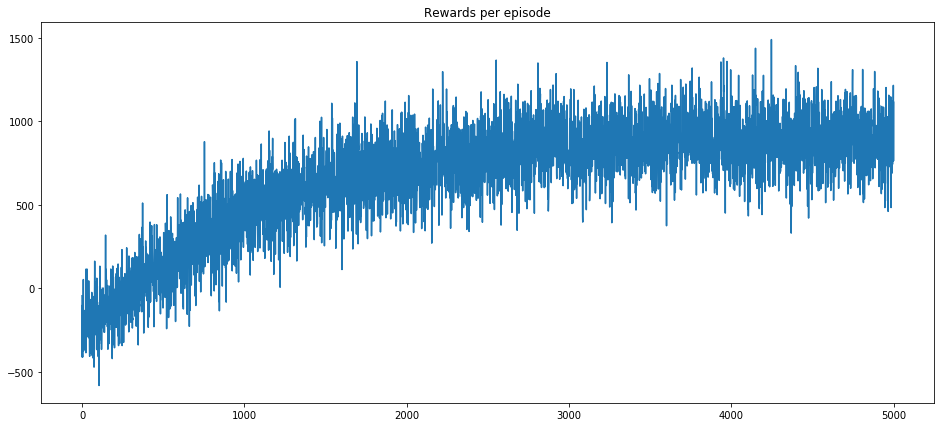

In [31]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [32]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

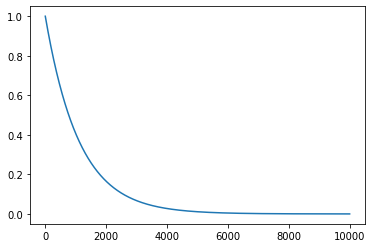

In [33]:
plt.plot(time, epsilon)
plt.show()

In [34]:
### Reducing Learning rate Further

In [ ]:
### DQN block2

In [35]:
#Under Test
learning_rate = 0.001
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [3, 17, 1]
episode 0, reward -230.0, memory_length 129, epsilon 0.999, time 734.0, rides 128
Initial State is  [3, 17, 1]
episode 1, reward -180.0, memory_length 255, epsilon 0.998001, time 730.0, rides 125
Initial State is  [3, 17, 1]
episode 2, reward -80.0, memory_length 379, epsilon 0.997002999, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 3, reward -142.0, memory_length 501, epsilon 0.996005996001, time 728.0, rides 121
Initial State is  [3, 17, 1]
episode 4, reward -98.0, memory_length 626, epsilon 0.995009990004999, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 5, reward -205.0, memory_length 754, epsilon 0.994014980014994, time 731.0, rides 127
Initial State is  [3, 17, 1]
episode 6, reward -230.0, memory_length 873, epsilon 0.993020965034979, time 722.0, rides 118
Initial State is  [3, 17, 1]
episode 7, reward -281.0, memory_length 1007, epsilon 0.9920279440699441, time 732.0, rides 133
Initial State is  [3, 17, 1]
episode 8, reward

episode 66, reward -178.0, memory_length 2000, epsilon 0.9351638519212846, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 67, reward -24.0, memory_length 2000, epsilon 0.9342286880693633, time 743.0, rides 125
Initial State is  [3, 17, 1]
episode 68, reward 92.0, memory_length 2000, epsilon 0.933294459381294, time 731.0, rides 125
Initial State is  [3, 17, 1]
episode 69, reward 25.0, memory_length 2000, epsilon 0.9323611649219127, time 727.0, rides 135
Initial State is  [3, 17, 1]
episode 70, reward -189.0, memory_length 2000, epsilon 0.9314288037569908, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 71, reward 27.0, memory_length 2000, epsilon 0.9304973749532338, time 737.0, rides 133
Initial State is  [3, 17, 1]
episode 72, reward -64.0, memory_length 2000, epsilon 0.9295668775782806, time 730.0, rides 132
Initial State is  [3, 17, 1]
episode 73, reward -8.0, memory_length 2000, epsilon 0.9286373107007023, time 722.0, rides 131
Initial State is  [3, 17, 1]
epi

episode 132, reward 309.0, memory_length 2000, epsilon 0.8754068367770318, time 730.0, rides 121
Initial State is  [3, 17, 1]
episode 133, reward -341.0, memory_length 2000, epsilon 0.8745314299402548, time 725.0, rides 122
Initial State is  [3, 17, 1]
episode 134, reward 53.0, memory_length 2000, epsilon 0.8736568985103146, time 730.0, rides 124
Initial State is  [3, 17, 1]
episode 135, reward -277.0, memory_length 2000, epsilon 0.8727832416118043, time 721.0, rides 125
Initial State is  [3, 17, 1]
episode 136, reward 12.0, memory_length 2000, epsilon 0.8719104583701925, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 137, reward -11.0, memory_length 2000, epsilon 0.8710385479118223, time 722.0, rides 132
Initial State is  [3, 17, 1]
episode 138, reward -173.0, memory_length 2000, epsilon 0.8701675093639105, time 725.0, rides 113
Initial State is  [3, 17, 1]
episode 139, reward -181.0, memory_length 2000, epsilon 0.8692973418545467, time 735.0, rides 127
Initial State is  [

episode 197, reward -170.0, memory_length 2000, epsilon 0.8202885863627752, time 731.0, rides 116
Initial State is  [3, 17, 1]
episode 198, reward -104.0, memory_length 2000, epsilon 0.8194682977764125, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 199, reward -137.0, memory_length 2000, epsilon 0.818648829478636, time 726.0, rides 126
Initial State is  [3, 17, 1]
episode 200, reward -288.0, memory_length 2000, epsilon 0.8178301806491574, time 725.0, rides 119
Initial State is  [3, 17, 1]
episode 201, reward 61.0, memory_length 2000, epsilon 0.8170123504685082, time 723.0, rides 111
Initial State is  [3, 17, 1]
episode 202, reward 85.0, memory_length 2000, epsilon 0.8161953381180397, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 203, reward -123.0, memory_length 2000, epsilon 0.8153791427799216, time 723.0, rides 119
Initial State is  [3, 17, 1]
episode 204, reward -150.0, memory_length 2000, epsilon 0.8145637636371417, time 732.0, rides 132
Initial State is  

episode 263, reward 26.0, memory_length 2000, epsilon 0.7678721062162944, time 727.0, rides 123
Initial State is  [3, 17, 1]
episode 264, reward 288.0, memory_length 2000, epsilon 0.7671042341100781, time 743.0, rides 119
Initial State is  [3, 17, 1]
episode 265, reward 9.0, memory_length 2000, epsilon 0.766337129875968, time 738.0, rides 130
Initial State is  [3, 17, 1]
episode 266, reward 44.0, memory_length 2000, epsilon 0.7655707927460921, time 728.0, rides 134
Initial State is  [3, 17, 1]
episode 267, reward 360.0, memory_length 2000, epsilon 0.764805221953346, time 738.0, rides 125
Initial State is  [3, 17, 1]
episode 268, reward 153.0, memory_length 2000, epsilon 0.7640404167313927, time 726.0, rides 126
Initial State is  [3, 17, 1]
episode 269, reward 11.0, memory_length 2000, epsilon 0.7632763763146613, time 726.0, rides 125
Initial State is  [3, 17, 1]
episode 270, reward -19.0, memory_length 2000, epsilon 0.7625130999383466, time 734.0, rides 123
Initial State is  [3, 17, 1]

episode 329, reward 290.0, memory_length 2000, epsilon 0.7188050416738131, time 734.0, rides 136
Initial State is  [3, 17, 1]
episode 330, reward 101.0, memory_length 2000, epsilon 0.7180862366321393, time 725.0, rides 124
Initial State is  [3, 17, 1]
episode 331, reward -410.0, memory_length 2000, epsilon 0.7173681503955072, time 732.0, rides 125
Initial State is  [3, 17, 1]
episode 332, reward 286.0, memory_length 2000, epsilon 0.7166507822451117, time 727.0, rides 134
Initial State is  [3, 17, 1]
episode 333, reward 82.0, memory_length 2000, epsilon 0.7159341314628666, time 729.0, rides 121
Initial State is  [3, 17, 1]
episode 334, reward 19.0, memory_length 2000, epsilon 0.7152181973314037, time 727.0, rides 125
Initial State is  [3, 17, 1]
episode 335, reward -2.0, memory_length 2000, epsilon 0.7145029791340722, time 735.0, rides 124
Initial State is  [3, 17, 1]
episode 336, reward 200.0, memory_length 2000, epsilon 0.7137884761549381, time 738.0, rides 126
Initial State is  [3, 1

episode 395, reward 82.0, memory_length 2000, epsilon 0.6728733649170395, time 732.0, rides 120
Initial State is  [3, 17, 1]
episode 396, reward -50.0, memory_length 2000, epsilon 0.6722004915521225, time 738.0, rides 139
Initial State is  [3, 17, 1]
episode 397, reward 175.0, memory_length 2000, epsilon 0.6715282910605703, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 398, reward -12.0, memory_length 2000, epsilon 0.6708567627695098, time 735.0, rides 117
Initial State is  [3, 17, 1]
episode 399, reward 81.0, memory_length 2000, epsilon 0.6701859060067403, time 726.0, rides 120
Initial State is  [3, 17, 1]
episode 400, reward -47.0, memory_length 2000, epsilon 0.6695157201007336, time 734.0, rides 120
Initial State is  [3, 17, 1]
episode 401, reward 179.0, memory_length 2000, epsilon 0.6688462043806328, time 724.0, rides 121
Initial State is  [3, 17, 1]
episode 402, reward 215.0, memory_length 2000, epsilon 0.6681773581762521, time 730.0, rides 128
Initial State is  [3, 1

episode 461, reward 311.0, memory_length 2000, epsilon 0.6298767245155701, time 732.0, rides 117
Initial State is  [3, 17, 1]
episode 462, reward 322.0, memory_length 2000, epsilon 0.6292468477910546, time 729.0, rides 135
Initial State is  [3, 17, 1]
episode 463, reward -73.0, memory_length 2000, epsilon 0.6286176009432635, time 731.0, rides 129
Initial State is  [3, 17, 1]
episode 464, reward 10.0, memory_length 2000, epsilon 0.6279889833423202, time 731.0, rides 127
Initial State is  [3, 17, 1]
episode 465, reward 167.0, memory_length 2000, epsilon 0.6273609943589779, time 731.0, rides 133
Initial State is  [3, 17, 1]
episode 466, reward 263.0, memory_length 2000, epsilon 0.6267336333646188, time 738.0, rides 120
Initial State is  [3, 17, 1]
episode 467, reward 131.0, memory_length 2000, epsilon 0.6261068997312542, time 729.0, rides 119
Initial State is  [3, 17, 1]
episode 468, reward 396.0, memory_length 2000, epsilon 0.6254807928315229, time 735.0, rides 117
Initial State is  [3, 

episode 527, reward 230.0, memory_length 2000, epsilon 0.5896275715050474, time 722.0, rides 124
Initial State is  [3, 17, 1]
episode 528, reward 431.0, memory_length 2000, epsilon 0.5890379439335424, time 734.0, rides 130
Initial State is  [3, 17, 1]
episode 529, reward -72.0, memory_length 2000, epsilon 0.5884489059896089, time 725.0, rides 124
Initial State is  [3, 17, 1]
episode 530, reward 162.0, memory_length 2000, epsilon 0.5878604570836192, time 725.0, rides 119
Initial State is  [3, 17, 1]
episode 531, reward 118.0, memory_length 2000, epsilon 0.5872725966265356, time 732.0, rides 139
Initial State is  [3, 17, 1]
episode 532, reward 215.0, memory_length 2000, epsilon 0.5866853240299091, time 730.0, rides 130
Initial State is  [3, 17, 1]
episode 533, reward 317.0, memory_length 2000, epsilon 0.5860986387058792, time 733.0, rides 132
Initial State is  [3, 17, 1]
episode 534, reward 102.0, memory_length 2000, epsilon 0.5855125400671733, time 725.0, rides 128
Initial State is  [3,

episode 593, reward 288.0, memory_length 2000, epsilon 0.5519503413089615, time 727.0, rides 119
Initial State is  [3, 17, 1]
episode 594, reward 145.0, memory_length 2000, epsilon 0.5513983909676525, time 735.0, rides 139
Initial State is  [3, 17, 1]
episode 595, reward 137.0, memory_length 2000, epsilon 0.5508469925766849, time 728.0, rides 121
Initial State is  [3, 17, 1]
episode 596, reward 336.0, memory_length 2000, epsilon 0.5502961455841082, time 730.0, rides 121
Initial State is  [3, 17, 1]
episode 597, reward 386.0, memory_length 2000, epsilon 0.5497458494385241, time 723.0, rides 120
Initial State is  [3, 17, 1]
episode 598, reward 450.0, memory_length 2000, epsilon 0.5491961035890855, time 735.0, rides 126
Initial State is  [3, 17, 1]
episode 599, reward 429.0, memory_length 2000, epsilon 0.5486469074854965, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 600, reward 426.0, memory_length 2000, epsilon 0.548098260578011, time 734.0, rides 125
Initial State is  [3, 

episode 659, reward 493.0, memory_length 2000, epsilon 0.5166806879356919, time 722.0, rides 125
Initial State is  [3, 17, 1]
episode 660, reward 166.0, memory_length 2000, epsilon 0.5161640072477562, time 732.0, rides 119
Initial State is  [3, 17, 1]
episode 661, reward 291.0, memory_length 2000, epsilon 0.5156478432405085, time 733.0, rides 122
Initial State is  [3, 17, 1]
episode 662, reward 340.0, memory_length 2000, epsilon 0.515132195397268, time 729.0, rides 133
Initial State is  [3, 17, 1]
episode 663, reward 278.0, memory_length 2000, epsilon 0.5146170632018707, time 726.0, rides 133
Initial State is  [3, 17, 1]
episode 664, reward 161.0, memory_length 2000, epsilon 0.5141024461386688, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 665, reward -20.0, memory_length 2000, epsilon 0.5135883436925301, time 737.0, rides 127
Initial State is  [3, 17, 1]
episode 666, reward 414.0, memory_length 2000, epsilon 0.5130747553488376, time 725.0, rides 130
Initial State is  [3, 

episode 724, reward 346.0, memory_length 2000, epsilon 0.4841489160264175, time 731.0, rides 127
Initial State is  [3, 17, 1]
episode 725, reward 520.0, memory_length 2000, epsilon 0.4836647671103911, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 726, reward 538.0, memory_length 2000, epsilon 0.4831811023432807, time 730.0, rides 130
Initial State is  [3, 17, 1]
episode 727, reward 271.0, memory_length 2000, epsilon 0.4826979212409374, time 737.0, rides 110
Initial State is  [3, 17, 1]
episode 728, reward 591.0, memory_length 2000, epsilon 0.48221522331969646, time 729.0, rides 113
Initial State is  [3, 17, 1]
episode 729, reward 195.0, memory_length 2000, epsilon 0.48173300809637676, time 731.0, rides 123
Initial State is  [3, 17, 1]
episode 730, reward 237.0, memory_length 2000, epsilon 0.48125127508828036, time 726.0, rides 147
Initial State is  [3, 17, 1]
episode 731, reward 409.0, memory_length 2000, epsilon 0.48077002381319206, time 733.0, rides 119
Initial State is 

episode 789, reward 686.0, memory_length 2000, epsilon 0.4536654424342049, time 731.0, rides 120
Initial State is  [3, 17, 1]
episode 790, reward 312.0, memory_length 2000, epsilon 0.45321177699177073, time 727.0, rides 136
Initial State is  [3, 17, 1]
episode 791, reward 345.0, memory_length 2000, epsilon 0.452758565214779, time 739.0, rides 122
Initial State is  [3, 17, 1]
episode 792, reward 412.0, memory_length 2000, epsilon 0.4523058066495642, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 793, reward 217.0, memory_length 2000, epsilon 0.45185350084291465, time 737.0, rides 137
Initial State is  [3, 17, 1]
episode 794, reward 322.0, memory_length 2000, epsilon 0.4514016473420717, time 731.0, rides 120
Initial State is  [3, 17, 1]
episode 795, reward 300.0, memory_length 2000, epsilon 0.45095024569472963, time 731.0, rides 123
Initial State is  [3, 17, 1]
episode 796, reward 108.0, memory_length 2000, epsilon 0.4504992954490349, time 733.0, rides 141
Initial State is  [

episode 854, reward 349.0, memory_length 2000, epsilon 0.4251013001293033, time 725.0, rides 139
Initial State is  [3, 17, 1]
episode 855, reward 690.0, memory_length 2000, epsilon 0.424676198829174, time 736.0, rides 129
Initial State is  [3, 17, 1]
episode 856, reward 611.0, memory_length 2000, epsilon 0.4242515226303448, time 722.0, rides 116
Initial State is  [3, 17, 1]
episode 857, reward 310.0, memory_length 2000, epsilon 0.42382727110771445, time 727.0, rides 138
Initial State is  [3, 17, 1]
episode 858, reward 292.0, memory_length 2000, epsilon 0.4234034438366067, time 732.0, rides 128
Initial State is  [3, 17, 1]
episode 859, reward 369.0, memory_length 2000, epsilon 0.4229800403927701, time 724.0, rides 124
Initial State is  [3, 17, 1]
episode 860, reward 413.0, memory_length 2000, epsilon 0.42255706035237733, time 726.0, rides 129
Initial State is  [3, 17, 1]
episode 861, reward 322.0, memory_length 2000, epsilon 0.42213450329202495, time 737.0, rides 118
Initial State is  [

episode 919, reward 346.0, memory_length 2000, epsilon 0.398335642234492, time 728.0, rides 127
Initial State is  [3, 17, 1]
episode 920, reward 289.0, memory_length 2000, epsilon 0.3979373065922575, time 734.0, rides 121
Initial State is  [3, 17, 1]
episode 921, reward 441.0, memory_length 2000, epsilon 0.39753936928566525, time 734.0, rides 120
Initial State is  [3, 17, 1]
episode 922, reward 535.0, memory_length 2000, epsilon 0.3971418299163796, time 727.0, rides 125
Initial State is  [3, 17, 1]
episode 923, reward 371.0, memory_length 2000, epsilon 0.3967446880864632, time 730.0, rides 134
Initial State is  [3, 17, 1]
episode 924, reward 611.0, memory_length 2000, epsilon 0.3963479433983767, time 729.0, rides 134
Initial State is  [3, 17, 1]
episode 925, reward 373.0, memory_length 2000, epsilon 0.3959515954549783, time 733.0, rides 126
Initial State is  [3, 17, 1]
episode 926, reward 829.0, memory_length 2000, epsilon 0.39555564385952335, time 730.0, rides 124
Initial State is  [3

episode 984, reward 341.0, memory_length 2000, epsilon 0.37325523075582717, time 734.0, rides 126
Initial State is  [3, 17, 1]
episode 985, reward 362.0, memory_length 2000, epsilon 0.37288197552507135, time 731.0, rides 130
Initial State is  [3, 17, 1]
episode 986, reward 862.0, memory_length 2000, epsilon 0.37250909354954626, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 987, reward 402.0, memory_length 2000, epsilon 0.37213658445599673, time 731.0, rides 135
Initial State is  [3, 17, 1]
episode 988, reward 404.0, memory_length 2000, epsilon 0.3717644478715407, time 732.0, rides 126
Initial State is  [3, 17, 1]
episode 989, reward 548.0, memory_length 2000, epsilon 0.3713926834236692, time 731.0, rides 124
Initial State is  [3, 17, 1]
episode 990, reward 591.0, memory_length 2000, epsilon 0.37102129074024554, time 721.0, rides 117
Initial State is  [3, 17, 1]
episode 991, reward 300.0, memory_length 2000, epsilon 0.3706502694495053, time 728.0, rides 134
Initial State is

episode 1049, reward 695.0, memory_length 2000, epsilon 0.349753957504439, time 736.0, rides 130
Initial State is  [3, 17, 1]
episode 1050, reward 669.0, memory_length 2000, epsilon 0.3494042035469346, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 1051, reward 674.0, memory_length 2000, epsilon 0.3490547993433876, time 731.0, rides 122
Initial State is  [3, 17, 1]
episode 1052, reward 603.0, memory_length 2000, epsilon 0.34870574454404424, time 728.0, rides 134
Initial State is  [3, 17, 1]
episode 1053, reward 818.0, memory_length 2000, epsilon 0.3483570387995002, time 725.0, rides 126
Initial State is  [3, 17, 1]
episode 1054, reward 508.0, memory_length 2000, epsilon 0.3480086817607007, time 725.0, rides 121
Initial State is  [3, 17, 1]
episode 1055, reward 319.0, memory_length 2000, epsilon 0.34766067307894, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 1056, reward 473.0, memory_length 2000, epsilon 0.34731301240586104, time 725.0, rides 110
Initial State 

episode 1114, reward 872.0, memory_length 2000, epsilon 0.32773239518253433, time 723.0, rides 132
Initial State is  [3, 17, 1]
episode 1115, reward 744.0, memory_length 2000, epsilon 0.3274046627873518, time 736.0, rides 123
Initial State is  [3, 17, 1]
episode 1116, reward 621.0, memory_length 2000, epsilon 0.32707725812456445, time 727.0, rides 117
Initial State is  [3, 17, 1]
episode 1117, reward 742.0, memory_length 2000, epsilon 0.32675018086643987, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 1118, reward 574.0, memory_length 2000, epsilon 0.32642343068557345, time 731.0, rides 126
Initial State is  [3, 17, 1]
episode 1119, reward 615.0, memory_length 2000, epsilon 0.3260970072548879, time 740.0, rides 114
Initial State is  [3, 17, 1]
episode 1120, reward 722.0, memory_length 2000, epsilon 0.325770910247633, time 731.0, rides 129
Initial State is  [3, 17, 1]
episode 1121, reward 589.0, memory_length 2000, epsilon 0.32544513933738534, time 730.0, rides 128
Initial S

episode 1179, reward 622.0, memory_length 2000, epsilon 0.30709737673437937, time 727.0, rides 122
Initial State is  [3, 17, 1]
episode 1180, reward 469.0, memory_length 2000, epsilon 0.30679027935764497, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 1181, reward 548.0, memory_length 2000, epsilon 0.3064834890782873, time 731.0, rides 120
Initial State is  [3, 17, 1]
episode 1182, reward 458.0, memory_length 2000, epsilon 0.306177005589209, time 723.0, rides 126
Initial State is  [3, 17, 1]
episode 1183, reward 496.0, memory_length 2000, epsilon 0.3058708285836198, time 730.0, rides 117
Initial State is  [3, 17, 1]
episode 1184, reward 599.0, memory_length 2000, epsilon 0.30556495775503617, time 731.0, rides 122
Initial State is  [3, 17, 1]
episode 1185, reward 724.0, memory_length 2000, epsilon 0.30525939279728115, time 724.0, rides 122
Initial State is  [3, 17, 1]
episode 1186, reward 382.0, memory_length 2000, epsilon 0.30495413340448385, time 734.0, rides 113
Initial S

episode 1244, reward 704.0, memory_length 2000, epsilon 0.28776160118260813, time 749.0, rides 117
Initial State is  [3, 17, 1]
episode 1245, reward 376.0, memory_length 2000, epsilon 0.2874738395814255, time 731.0, rides 139
Initial State is  [3, 17, 1]
episode 1246, reward 381.0, memory_length 2000, epsilon 0.2871863657418441, time 735.0, rides 120
Initial State is  [3, 17, 1]
episode 1247, reward 393.0, memory_length 2000, epsilon 0.28689917937610226, time 725.0, rides 120
Initial State is  [3, 17, 1]
episode 1248, reward 872.0, memory_length 2000, epsilon 0.2866122801967262, time 733.0, rides 124
Initial State is  [3, 17, 1]
episode 1249, reward 591.0, memory_length 2000, epsilon 0.28632566791652947, time 730.0, rides 114
Initial State is  [3, 17, 1]
episode 1250, reward 396.0, memory_length 2000, epsilon 0.28603934224861294, time 723.0, rides 121
Initial State is  [3, 17, 1]
episode 1251, reward 507.0, memory_length 2000, epsilon 0.2857533029063643, time 728.0, rides 109
Initial S

episode 1309, reward 680.0, memory_length 2000, epsilon 0.2696432642822646, time 738.0, rides 120
Initial State is  [3, 17, 1]
episode 1310, reward 645.0, memory_length 2000, epsilon 0.26937362101798235, time 728.0, rides 119
Initial State is  [3, 17, 1]
episode 1311, reward 579.0, memory_length 2000, epsilon 0.26910424739696437, time 731.0, rides 122
Initial State is  [3, 17, 1]
episode 1312, reward 873.0, memory_length 2000, epsilon 0.2688351431495674, time 721.0, rides 126
Initial State is  [3, 17, 1]
episode 1313, reward 803.0, memory_length 2000, epsilon 0.26856630800641784, time 728.0, rides 124
Initial State is  [3, 17, 1]
episode 1314, reward 448.0, memory_length 2000, epsilon 0.2682977416984114, time 722.0, rides 117
Initial State is  [3, 17, 1]
episode 1315, reward 602.0, memory_length 2000, epsilon 0.268029443956713, time 723.0, rides 129
Initial State is  [3, 17, 1]
episode 1316, reward 638.0, memory_length 2000, epsilon 0.2677614145127563, time 730.0, rides 115
Initial Sta

episode 1374, reward 618.0, memory_length 2000, epsilon 0.2526657124299791, time 727.0, rides 127
Initial State is  [3, 17, 1]
episode 1375, reward 716.0, memory_length 2000, epsilon 0.2524130467175491, time 723.0, rides 113
Initial State is  [3, 17, 1]
episode 1376, reward 773.0, memory_length 2000, epsilon 0.2521606336708316, time 724.0, rides 132
Initial State is  [3, 17, 1]
episode 1377, reward 921.0, memory_length 2000, epsilon 0.25190847303716074, time 729.0, rides 138
Initial State is  [3, 17, 1]
episode 1378, reward 974.0, memory_length 2000, epsilon 0.25165656456412355, time 731.0, rides 129
Initial State is  [3, 17, 1]
episode 1379, reward 514.0, memory_length 2000, epsilon 0.25140490799955945, time 730.0, rides 146
Initial State is  [3, 17, 1]
episode 1380, reward 594.0, memory_length 2000, epsilon 0.25115350309155987, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 1381, reward 570.0, memory_length 2000, epsilon 0.2509023495884683, time 722.0, rides 122
Initial S

episode 1439, reward 445.0, memory_length 2000, epsilon 0.23675711836406457, time 736.0, rides 131
Initial State is  [3, 17, 1]
episode 1440, reward 762.0, memory_length 2000, epsilon 0.2365203612457005, time 736.0, rides 123
Initial State is  [3, 17, 1]
episode 1441, reward 644.0, memory_length 2000, epsilon 0.2362838408844548, time 725.0, rides 115
Initial State is  [3, 17, 1]
episode 1442, reward 665.0, memory_length 2000, epsilon 0.23604755704357036, time 727.0, rides 122
Initial State is  [3, 17, 1]
episode 1443, reward 784.0, memory_length 2000, epsilon 0.2358115094865268, time 725.0, rides 122
Initial State is  [3, 17, 1]
episode 1444, reward 423.0, memory_length 2000, epsilon 0.23557569797704025, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 1445, reward 697.0, memory_length 2000, epsilon 0.2353401222790632, time 723.0, rides 133
Initial State is  [3, 17, 1]
episode 1446, reward 873.0, memory_length 2000, epsilon 0.23510478215678413, time 729.0, rides 139
Initial S

episode 1504, reward 602.0, memory_length 2000, epsilon 0.22185017728351172, time 734.0, rides 122
Initial State is  [3, 17, 1]
episode 1505, reward 880.0, memory_length 2000, epsilon 0.2216283271062282, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 1506, reward 777.0, memory_length 2000, epsilon 0.22140669877912197, time 726.0, rides 132
Initial State is  [3, 17, 1]
episode 1507, reward 713.0, memory_length 2000, epsilon 0.22118529208034285, time 735.0, rides 131
Initial State is  [3, 17, 1]
episode 1508, reward 681.0, memory_length 2000, epsilon 0.2209641067882625, time 725.0, rides 128
Initial State is  [3, 17, 1]
episode 1509, reward 800.0, memory_length 2000, epsilon 0.22074314268147424, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 1510, reward 690.0, memory_length 2000, epsilon 0.22052239953879277, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 1511, reward 454.0, memory_length 2000, epsilon 0.22030187713925398, time 736.0, rides 120
Initial

episode 1569, reward 863.0, memory_length 2000, epsilon 0.207881822100247, time 730.0, rides 114
Initial State is  [3, 17, 1]
episode 1570, reward 913.0, memory_length 2000, epsilon 0.20767394027814676, time 725.0, rides 132
Initial State is  [3, 17, 1]
episode 1571, reward 831.0, memory_length 2000, epsilon 0.2074662663378686, time 726.0, rides 120
Initial State is  [3, 17, 1]
episode 1572, reward 838.0, memory_length 2000, epsilon 0.20725880007153075, time 737.0, rides 118
Initial State is  [3, 17, 1]
episode 1573, reward 856.0, memory_length 2000, epsilon 0.20705154127145922, time 735.0, rides 126
Initial State is  [3, 17, 1]
episode 1574, reward 752.0, memory_length 2000, epsilon 0.20684448973018776, time 730.0, rides 124
Initial State is  [3, 17, 1]
episode 1575, reward 798.0, memory_length 2000, epsilon 0.20663764524045758, time 723.0, rides 118
Initial State is  [3, 17, 1]
episode 1576, reward 875.0, memory_length 2000, epsilon 0.20643100759521713, time 726.0, rides 121
Initial 

episode 1634, reward 645.0, memory_length 2000, epsilon 0.19479295661996557, time 729.0, rides 122
Initial State is  [3, 17, 1]
episode 1635, reward 961.0, memory_length 2000, epsilon 0.1945981636633456, time 726.0, rides 118
Initial State is  [3, 17, 1]
episode 1636, reward 553.0, memory_length 2000, epsilon 0.19440356549968224, time 738.0, rides 134
Initial State is  [3, 17, 1]
episode 1637, reward 724.0, memory_length 2000, epsilon 0.19420916193418256, time 726.0, rides 135
Initial State is  [3, 17, 1]
episode 1638, reward 692.0, memory_length 2000, epsilon 0.19401495277224837, time 727.0, rides 128
Initial State is  [3, 17, 1]
episode 1639, reward 727.0, memory_length 2000, epsilon 0.19382093781947612, time 731.0, rides 117
Initial State is  [3, 17, 1]
episode 1640, reward 630.0, memory_length 2000, epsilon 0.19362711688165665, time 728.0, rides 132
Initial State is  [3, 17, 1]
episode 1641, reward 784.0, memory_length 2000, epsilon 0.193433489764775, time 728.0, rides 124
Initial 

episode 1699, reward 777.0, memory_length 2000, epsilon 0.18252820552270246, time 727.0, rides 121
Initial State is  [3, 17, 1]
episode 1700, reward 837.0, memory_length 2000, epsilon 0.18234567731717977, time 742.0, rides 113
Initial State is  [3, 17, 1]
episode 1701, reward 1011.0, memory_length 2000, epsilon 0.1821633316398626, time 724.0, rides 115
Initial State is  [3, 17, 1]
episode 1702, reward 769.0, memory_length 2000, epsilon 0.18198116830822272, time 726.0, rides 120
Initial State is  [3, 17, 1]
episode 1703, reward 925.0, memory_length 2000, epsilon 0.1817991871399145, time 730.0, rides 120
Initial State is  [3, 17, 1]
episode 1704, reward 1197.0, memory_length 2000, epsilon 0.18161738795277457, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 1705, reward 626.0, memory_length 2000, epsilon 0.1814357705648218, time 734.0, rides 128
Initial State is  [3, 17, 1]
episode 1706, reward 850.0, memory_length 2000, epsilon 0.18125433479425698, time 727.0, rides 127
Initia

episode 1764, reward 867.0, memory_length 2000, epsilon 0.17103568008538103, time 732.0, rides 118
Initial State is  [3, 17, 1]
episode 1765, reward 1062.0, memory_length 2000, epsilon 0.17086464440529564, time 723.0, rides 117
Initial State is  [3, 17, 1]
episode 1766, reward 944.0, memory_length 2000, epsilon 0.17069377976089034, time 733.0, rides 119
Initial State is  [3, 17, 1]
episode 1767, reward 879.0, memory_length 2000, epsilon 0.17052308598112945, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 1768, reward 1142.0, memory_length 2000, epsilon 0.17035256289514833, time 729.0, rides 118
Initial State is  [3, 17, 1]
episode 1769, reward 849.0, memory_length 2000, epsilon 0.17018221033225317, time 734.0, rides 124
Initial State is  [3, 17, 1]
episode 1770, reward 1013.0, memory_length 2000, epsilon 0.17001202812192093, time 726.0, rides 144
Initial State is  [3, 17, 1]
episode 1771, reward 1032.0, memory_length 2000, epsilon 0.169842016093799, time 733.0, rides 120
Ini

episode 1829, reward 738.0, memory_length 2000, epsilon 0.16026675865517317, time 725.0, rides 121
Initial State is  [3, 17, 1]
episode 1830, reward 798.0, memory_length 2000, epsilon 0.160106491896518, time 725.0, rides 115
Initial State is  [3, 17, 1]
episode 1831, reward 996.0, memory_length 2000, epsilon 0.15994638540462147, time 732.0, rides 120
Initial State is  [3, 17, 1]
episode 1832, reward 969.0, memory_length 2000, epsilon 0.15978643901921685, time 725.0, rides 124
Initial State is  [3, 17, 1]
episode 1833, reward 662.0, memory_length 2000, epsilon 0.15962665258019765, time 730.0, rides 116
Initial State is  [3, 17, 1]
episode 1834, reward 837.0, memory_length 2000, epsilon 0.15946702592761744, time 733.0, rides 132
Initial State is  [3, 17, 1]
episode 1835, reward 647.0, memory_length 2000, epsilon 0.15930755890168982, time 731.0, rides 124
Initial State is  [3, 17, 1]
episode 1836, reward 934.0, memory_length 2000, epsilon 0.15914825134278812, time 733.0, rides 120
Initial

episode 1894, reward 683.0, memory_length 2000, epsilon 0.1501758809449194, time 725.0, rides 128
Initial State is  [3, 17, 1]
episode 1895, reward 1089.0, memory_length 2000, epsilon 0.15002570506397447, time 730.0, rides 119
Initial State is  [3, 17, 1]
episode 1896, reward 707.0, memory_length 2000, epsilon 0.1498756793589105, time 722.0, rides 118
Initial State is  [3, 17, 1]
episode 1897, reward 903.0, memory_length 2000, epsilon 0.14972580367955157, time 730.0, rides 140
Initial State is  [3, 17, 1]
episode 1898, reward 802.0, memory_length 2000, epsilon 0.14957607787587202, time 726.0, rides 136
Initial State is  [3, 17, 1]
episode 1899, reward 802.0, memory_length 2000, epsilon 0.14942650179799613, time 731.0, rides 123
Initial State is  [3, 17, 1]
episode 1900, reward 1041.0, memory_length 2000, epsilon 0.14927707529619813, time 724.0, rides 134
Initial State is  [3, 17, 1]
episode 1901, reward 909.0, memory_length 2000, epsilon 0.14912779822090194, time 736.0, rides 113
Initi

episode 1959, reward 795.0, memory_length 2000, epsilon 0.14072035528032842, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 1960, reward 736.0, memory_length 2000, epsilon 0.1405796349250481, time 722.0, rides 121
Initial State is  [3, 17, 1]
episode 1961, reward 952.0, memory_length 2000, epsilon 0.14043905529012304, time 729.0, rides 123
Initial State is  [3, 17, 1]
episode 1962, reward 501.0, memory_length 2000, epsilon 0.14029861623483292, time 732.0, rides 132
Initial State is  [3, 17, 1]
episode 1963, reward 817.0, memory_length 2000, epsilon 0.1401583176185981, time 725.0, rides 118
Initial State is  [3, 17, 1]
episode 1964, reward 558.0, memory_length 2000, epsilon 0.1400181593009795, time 721.0, rides 136
Initial State is  [3, 17, 1]
episode 1965, reward 855.0, memory_length 2000, epsilon 0.1398781411416785, time 736.0, rides 118
Initial State is  [3, 17, 1]
episode 1966, reward 1071.0, memory_length 2000, epsilon 0.13973826300053682, time 728.0, rides 129
Initial 

episode 2024, reward 539.0, memory_length 2000, epsilon 0.1318601779834725, time 729.0, rides 141
Initial State is  [3, 17, 1]
episode 2025, reward 878.0, memory_length 2000, epsilon 0.13172831780548902, time 735.0, rides 122
Initial State is  [3, 17, 1]
episode 2026, reward 793.0, memory_length 2000, epsilon 0.13159658948768352, time 726.0, rides 112
Initial State is  [3, 17, 1]
episode 2027, reward 755.0, memory_length 2000, epsilon 0.13146499289819583, time 726.0, rides 130
Initial State is  [3, 17, 1]
episode 2028, reward 663.0, memory_length 2000, epsilon 0.13133352790529762, time 729.0, rides 121
Initial State is  [3, 17, 1]
episode 2029, reward 960.0, memory_length 2000, epsilon 0.13120219437739233, time 734.0, rides 125
Initial State is  [3, 17, 1]
episode 2030, reward 1106.0, memory_length 2000, epsilon 0.13107099218301493, time 728.0, rides 130
Initial State is  [3, 17, 1]
episode 2031, reward 1066.0, memory_length 2000, epsilon 0.13093992119083192, time 730.0, rides 127
Init

episode 2089, reward 756.0, memory_length 2000, epsilon 0.12355786412844308, time 734.0, rides 115
Initial State is  [3, 17, 1]
episode 2090, reward 631.0, memory_length 2000, epsilon 0.12343430626431463, time 729.0, rides 135
Initial State is  [3, 17, 1]
episode 2091, reward 873.0, memory_length 2000, epsilon 0.12331087195805032, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 2092, reward 621.0, memory_length 2000, epsilon 0.12318756108609227, time 726.0, rides 136
Initial State is  [3, 17, 1]
episode 2093, reward 752.0, memory_length 2000, epsilon 0.12306437352500618, time 721.0, rides 124
Initial State is  [3, 17, 1]
episode 2094, reward 954.0, memory_length 2000, epsilon 0.12294130915148117, time 726.0, rides 130
Initial State is  [3, 17, 1]
episode 2095, reward 672.0, memory_length 2000, epsilon 0.12281836784232969, time 725.0, rides 122
Initial State is  [3, 17, 1]
episode 2096, reward 964.0, memory_length 2000, epsilon 0.12269554947448735, time 728.0, rides 143
Initi

episode 2154, reward 597.0, memory_length 2000, epsilon 0.11577828895313887, time 732.0, rides 123
Initial State is  [3, 17, 1]
episode 2155, reward 964.0, memory_length 2000, epsilon 0.11566251066418573, time 725.0, rides 140
Initial State is  [3, 17, 1]
episode 2156, reward 661.0, memory_length 2000, epsilon 0.11554684815352155, time 732.0, rides 122
Initial State is  [3, 17, 1]
episode 2157, reward 514.0, memory_length 2000, epsilon 0.11543130130536802, time 736.0, rides 118
Initial State is  [3, 17, 1]
episode 2158, reward 1001.0, memory_length 2000, epsilon 0.11531587000406265, time 736.0, rides 129
Initial State is  [3, 17, 1]
episode 2159, reward 957.0, memory_length 2000, epsilon 0.1152005541340586, time 722.0, rides 125
Initial State is  [3, 17, 1]
episode 2160, reward 767.0, memory_length 2000, epsilon 0.11508535357992454, time 730.0, rides 123
Initial State is  [3, 17, 1]
episode 2161, reward 671.0, memory_length 2000, epsilon 0.11497026822634461, time 730.0, rides 125
Initi

episode 2218, reward 551.0, memory_length 2000, epsilon 0.10859713639263872, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 2219, reward 926.0, memory_length 2000, epsilon 0.10848853925624609, time 744.0, rides 112
Initial State is  [3, 17, 1]
episode 2220, reward 778.0, memory_length 2000, epsilon 0.10838005071698985, time 730.0, rides 118
Initial State is  [3, 17, 1]
episode 2221, reward 759.0, memory_length 2000, epsilon 0.10827167066627286, time 731.0, rides 136
Initial State is  [3, 17, 1]
episode 2222, reward 873.0, memory_length 2000, epsilon 0.10816339899560658, time 734.0, rides 135
Initial State is  [3, 17, 1]
episode 2223, reward 1019.0, memory_length 2000, epsilon 0.10805523559661097, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 2224, reward 1107.0, memory_length 2000, epsilon 0.10794718036101436, time 726.0, rides 138
Initial State is  [3, 17, 1]
episode 2225, reward 1025.0, memory_length 2000, epsilon 0.10783923318065335, time 735.0, rides 134
In

episode 2282, reward 901.0, memory_length 2000, epsilon 0.10186139507947568, time 733.0, rides 125
Initial State is  [3, 17, 1]
episode 2283, reward 782.0, memory_length 2000, epsilon 0.1017595336843962, time 731.0, rides 132
Initial State is  [3, 17, 1]
episode 2284, reward 451.0, memory_length 2000, epsilon 0.10165777415071181, time 738.0, rides 126
Initial State is  [3, 17, 1]
episode 2285, reward 783.0, memory_length 2000, epsilon 0.1015561163765611, time 726.0, rides 133
Initial State is  [3, 17, 1]
episode 2286, reward 1126.0, memory_length 2000, epsilon 0.10145456026018454, time 740.0, rides 130
Initial State is  [3, 17, 1]
episode 2287, reward 1040.0, memory_length 2000, epsilon 0.10135310569992435, time 730.0, rides 133
Initial State is  [3, 17, 1]
episode 2288, reward 944.0, memory_length 2000, epsilon 0.10125175259422443, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 2289, reward 710.0, memory_length 2000, epsilon 0.10115050084163021, time 736.0, rides 119
Initi

episode 2346, reward 823.0, memory_length 2000, epsilon 0.09554343836492137, time 735.0, rides 122
Initial State is  [3, 17, 1]
episode 2347, reward 969.0, memory_length 2000, epsilon 0.09544789492655645, time 728.0, rides 120
Initial State is  [3, 17, 1]
episode 2348, reward 851.0, memory_length 2000, epsilon 0.09535244703162989, time 736.0, rides 122
Initial State is  [3, 17, 1]
episode 2349, reward 906.0, memory_length 2000, epsilon 0.09525709458459826, time 730.0, rides 125
Initial State is  [3, 17, 1]
episode 2350, reward 1029.0, memory_length 2000, epsilon 0.09516183749001367, time 729.0, rides 130
Initial State is  [3, 17, 1]
episode 2351, reward 1056.0, memory_length 2000, epsilon 0.09506667565252365, time 722.0, rides 125
Initial State is  [3, 17, 1]
episode 2352, reward 1008.0, memory_length 2000, epsilon 0.09497160897687112, time 736.0, rides 129
Initial State is  [3, 17, 1]
episode 2353, reward 874.0, memory_length 2000, epsilon 0.09487663736789426, time 734.0, rides 128
In

episode 2410, reward 823.0, memory_length 2000, epsilon 0.08961735314413405, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 2411, reward 821.0, memory_length 2000, epsilon 0.08952773579098991, time 733.0, rides 121
Initial State is  [3, 17, 1]
episode 2412, reward 778.0, memory_length 2000, epsilon 0.08943820805519892, time 735.0, rides 123
Initial State is  [3, 17, 1]
episode 2413, reward 685.0, memory_length 2000, epsilon 0.08934876984714372, time 729.0, rides 132
Initial State is  [3, 17, 1]
episode 2414, reward 1050.0, memory_length 2000, epsilon 0.08925942107729658, time 723.0, rides 131
Initial State is  [3, 17, 1]
episode 2415, reward 1149.0, memory_length 2000, epsilon 0.08917016165621929, time 728.0, rides 126
Initial State is  [3, 17, 1]
episode 2416, reward 666.0, memory_length 2000, epsilon 0.08908099149456307, time 730.0, rides 119
Initial State is  [3, 17, 1]
episode 2417, reward 897.0, memory_length 2000, epsilon 0.08899191050306851, time 736.0, rides 132
Ini

episode 2474, reward 791.0, memory_length 2000, epsilon 0.08405883357353715, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 2475, reward 878.0, memory_length 2000, epsilon 0.0839747747399636, time 740.0, rides 126
Initial State is  [3, 17, 1]
episode 2476, reward 807.0, memory_length 2000, epsilon 0.08389079996522364, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 2477, reward 1107.0, memory_length 2000, epsilon 0.08380690916525842, time 721.0, rides 128
Initial State is  [3, 17, 1]
episode 2478, reward 809.0, memory_length 2000, epsilon 0.08372310225609315, time 733.0, rides 127
Initial State is  [3, 17, 1]
episode 2479, reward 1017.0, memory_length 2000, epsilon 0.08363937915383707, time 734.0, rides 111
Initial State is  [3, 17, 1]
episode 2480, reward 891.0, memory_length 2000, epsilon 0.08355573977468322, time 733.0, rides 134
Initial State is  [3, 17, 1]
episode 2481, reward 1208.0, memory_length 2000, epsilon 0.08347218403490854, time 729.0, rides 117
Ini

episode 2538, reward 1029.0, memory_length 2000, epsilon 0.07884508138038125, time 733.0, rides 114
Initial State is  [3, 17, 1]
episode 2539, reward 818.0, memory_length 2000, epsilon 0.07876623629900087, time 722.0, rides 126
Initial State is  [3, 17, 1]
episode 2540, reward 850.0, memory_length 2000, epsilon 0.07868747006270187, time 727.0, rides 107
Initial State is  [3, 17, 1]
episode 2541, reward 690.0, memory_length 2000, epsilon 0.07860878259263916, time 724.0, rides 113
Initial State is  [3, 17, 1]
episode 2542, reward 763.0, memory_length 2000, epsilon 0.07853017381004652, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 2543, reward 1149.0, memory_length 2000, epsilon 0.07845164363623648, time 721.0, rides 121
Initial State is  [3, 17, 1]
episode 2544, reward 984.0, memory_length 2000, epsilon 0.07837319199260025, time 731.0, rides 133
Initial State is  [3, 17, 1]
episode 2545, reward 832.0, memory_length 2000, epsilon 0.07829481880060765, time 724.0, rides 117
Ini

episode 2602, reward 1062.0, memory_length 2000, epsilon 0.07395471235560894, time 721.0, rides 125
Initial State is  [3, 17, 1]
episode 2603, reward 967.0, memory_length 2000, epsilon 0.07388075764325333, time 725.0, rides 124
Initial State is  [3, 17, 1]
episode 2604, reward 918.0, memory_length 2000, epsilon 0.07380687688561008, time 722.0, rides 134
Initial State is  [3, 17, 1]
episode 2605, reward 838.0, memory_length 2000, epsilon 0.07373307000872446, time 725.0, rides 131
Initial State is  [3, 17, 1]
episode 2606, reward 748.0, memory_length 2000, epsilon 0.07365933693871574, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 2607, reward 938.0, memory_length 2000, epsilon 0.07358567760177702, time 730.0, rides 114
Initial State is  [3, 17, 1]
episode 2608, reward 856.0, memory_length 2000, epsilon 0.07351209192417524, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 2609, reward 1101.0, memory_length 2000, epsilon 0.07343857983225106, time 725.0, rides 126
Ini

episode 2666, reward 733.0, memory_length 2000, epsilon 0.06936766864650311, time 732.0, rides 136
Initial State is  [3, 17, 1]
episode 2667, reward 829.0, memory_length 2000, epsilon 0.06929830097785661, time 733.0, rides 134
Initial State is  [3, 17, 1]
episode 2668, reward 787.0, memory_length 2000, epsilon 0.06922900267687875, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 2669, reward 1232.0, memory_length 2000, epsilon 0.06915977367420187, time 736.0, rides 122
Initial State is  [3, 17, 1]
episode 2670, reward 899.0, memory_length 2000, epsilon 0.06909061390052766, time 728.0, rides 134
Initial State is  [3, 17, 1]
episode 2671, reward 1005.0, memory_length 2000, epsilon 0.06902152328662714, time 733.0, rides 121
Initial State is  [3, 17, 1]
episode 2672, reward 1148.0, memory_length 2000, epsilon 0.06895250176334052, time 725.0, rides 121
Initial State is  [3, 17, 1]
episode 2673, reward 1155.0, memory_length 2000, epsilon 0.06888354926157718, time 725.0, rides 130
I

episode 2730, reward 928.0, memory_length 2000, epsilon 0.06506513648938707, time 733.0, rides 113
Initial State is  [3, 17, 1]
episode 2731, reward 746.0, memory_length 2000, epsilon 0.06500007135289768, time 725.0, rides 114
Initial State is  [3, 17, 1]
episode 2732, reward 1237.0, memory_length 2000, epsilon 0.06493507128154478, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 2733, reward 935.0, memory_length 2000, epsilon 0.06487013621026325, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 2734, reward 1013.0, memory_length 2000, epsilon 0.06480526607405299, time 729.0, rides 134
Initial State is  [3, 17, 1]
episode 2735, reward 1025.0, memory_length 2000, epsilon 0.06474046080797893, time 725.0, rides 120
Initial State is  [3, 17, 1]
episode 2736, reward 806.0, memory_length 2000, epsilon 0.06467572034717095, time 730.0, rides 103
Initial State is  [3, 17, 1]
episode 2737, reward 1006.0, memory_length 2000, epsilon 0.06461104462682378, time 730.0, rides 120
I

episode 2794, reward 904.0, memory_length 2000, epsilon 0.06102946904495655, time 732.0, rides 129
Initial State is  [3, 17, 1]
episode 2795, reward 901.0, memory_length 2000, epsilon 0.06096843957591159, time 731.0, rides 126
Initial State is  [3, 17, 1]
episode 2796, reward 1175.0, memory_length 2000, epsilon 0.06090747113633568, time 732.0, rides 124
Initial State is  [3, 17, 1]
episode 2797, reward 1380.0, memory_length 2000, epsilon 0.06084656366519934, time 722.0, rides 122
Initial State is  [3, 17, 1]
episode 2798, reward 895.0, memory_length 2000, epsilon 0.06078571710153414, time 730.0, rides 118
Initial State is  [3, 17, 1]
episode 2799, reward 917.0, memory_length 2000, epsilon 0.06072493138443261, time 726.0, rides 112
Initial State is  [3, 17, 1]
episode 2800, reward 1041.0, memory_length 2000, epsilon 0.060664206453048174, time 721.0, rides 131
Initial State is  [3, 17, 1]
episode 2801, reward 1137.0, memory_length 2000, epsilon 0.06060354224659512, time 728.0, rides 122


episode 2858, reward 1022.0, memory_length 2000, epsilon 0.05724411401975369, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 2859, reward 973.0, memory_length 2000, epsilon 0.057186869905733934, time 727.0, rides 124
Initial State is  [3, 17, 1]
episode 2860, reward 726.0, memory_length 2000, epsilon 0.0571296830358282, time 726.0, rides 131
Initial State is  [3, 17, 1]
episode 2861, reward 1210.0, memory_length 2000, epsilon 0.05707255335279238, time 729.0, rides 125
Initial State is  [3, 17, 1]
episode 2862, reward 959.0, memory_length 2000, epsilon 0.057015480799439584, time 732.0, rides 120
Initial State is  [3, 17, 1]
episode 2863, reward 799.0, memory_length 2000, epsilon 0.05695846531864014, time 725.0, rides 117
Initial State is  [3, 17, 1]
episode 2864, reward 934.0, memory_length 2000, epsilon 0.0569015068533215, time 723.0, rides 123
Initial State is  [3, 17, 1]
episode 2865, reward 934.0, memory_length 2000, epsilon 0.05684460534646818, time 727.0, rides 129
Ini

episode 2922, reward 1142.0, memory_length 2000, epsilon 0.05369354577692105, time 729.0, rides 131
Initial State is  [3, 17, 1]
episode 2923, reward 1019.0, memory_length 2000, epsilon 0.053639852231144126, time 735.0, rides 115
Initial State is  [3, 17, 1]
episode 2924, reward 1135.0, memory_length 2000, epsilon 0.053586212378912985, time 730.0, rides 126
Initial State is  [3, 17, 1]
episode 2925, reward 1157.0, memory_length 2000, epsilon 0.05353262616653407, time 731.0, rides 132
Initial State is  [3, 17, 1]
episode 2926, reward 1120.0, memory_length 2000, epsilon 0.053479093540367534, time 733.0, rides 128
Initial State is  [3, 17, 1]
episode 2927, reward 856.0, memory_length 2000, epsilon 0.05342561444682717, time 732.0, rides 131
Initial State is  [3, 17, 1]
episode 2928, reward 926.0, memory_length 2000, epsilon 0.05337218883238034, time 728.0, rides 121
Initial State is  [3, 17, 1]
episode 2929, reward 1183.0, memory_length 2000, epsilon 0.053318816643547956, time 724.0, rides

episode 2986, reward 1022.0, memory_length 2000, epsilon 0.05036320165778891, time 723.0, rides 129
Initial State is  [3, 17, 1]
episode 2987, reward 1072.0, memory_length 2000, epsilon 0.05031283845613112, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 2988, reward 963.0, memory_length 2000, epsilon 0.05026252561767499, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 2989, reward 1277.0, memory_length 2000, epsilon 0.05021226309205731, time 723.0, rides 122
Initial State is  [3, 17, 1]
episode 2990, reward 1099.0, memory_length 2000, epsilon 0.05016205082896526, time 729.0, rides 122
Initial State is  [3, 17, 1]
episode 2991, reward 1052.0, memory_length 2000, epsilon 0.05011188877813629, time 726.0, rides 125
Initial State is  [3, 17, 1]
episode 2992, reward 1221.0, memory_length 2000, epsilon 0.05006177688935816, time 739.0, rides 125
Initial State is  [3, 17, 1]
episode 2993, reward 964.0, memory_length 2000, epsilon 0.0500117151124688, time 729.0, rides 126


episode 3050, reward 1116.0, memory_length 2000, epsilon 0.04723942225311833, time 725.0, rides 121
Initial State is  [3, 17, 1]
episode 3051, reward 1002.0, memory_length 2000, epsilon 0.04719218283086521, time 726.0, rides 119
Initial State is  [3, 17, 1]
episode 3052, reward 1121.0, memory_length 2000, epsilon 0.047144990648034346, time 730.0, rides 120
Initial State is  [3, 17, 1]
episode 3053, reward 1122.0, memory_length 2000, epsilon 0.04709784565738631, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 3054, reward 1267.0, memory_length 2000, epsilon 0.047050747811728924, time 728.0, rides 117
Initial State is  [3, 17, 1]
episode 3055, reward 1316.0, memory_length 2000, epsilon 0.047003697063917195, time 730.0, rides 119
Initial State is  [3, 17, 1]
episode 3056, reward 1078.0, memory_length 2000, epsilon 0.04695669336685328, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 3057, reward 1134.0, memory_length 2000, epsilon 0.04690973667348643, time 742.0, ride

episode 3114, reward 1169.0, memory_length 2000, epsilon 0.0443093953790225, time 722.0, rides 128
Initial State is  [3, 17, 1]
episode 3115, reward 1386.0, memory_length 2000, epsilon 0.04426508598364348, time 728.0, rides 136
Initial State is  [3, 17, 1]
episode 3116, reward 1088.0, memory_length 2000, epsilon 0.044220820897659836, time 727.0, rides 122
Initial State is  [3, 17, 1]
episode 3117, reward 1210.0, memory_length 2000, epsilon 0.044176600076762176, time 731.0, rides 126
Initial State is  [3, 17, 1]
episode 3118, reward 1219.0, memory_length 2000, epsilon 0.04413242347668542, time 729.0, rides 108
Initial State is  [3, 17, 1]
episode 3119, reward 934.0, memory_length 2000, epsilon 0.04408829105320873, time 731.0, rides 116
Initial State is  [3, 17, 1]
episode 3120, reward 698.0, memory_length 2000, epsilon 0.044044202762155524, time 730.0, rides 128
Initial State is  [3, 17, 1]
episode 3121, reward 1042.0, memory_length 2000, epsilon 0.04400015855939337, time 735.0, rides 1

episode 3178, reward 1252.0, memory_length 2000, epsilon 0.04156110352778373, time 732.0, rides 119
Initial State is  [3, 17, 1]
episode 3179, reward 1077.0, memory_length 2000, epsilon 0.04151954242425594, time 734.0, rides 138
Initial State is  [3, 17, 1]
episode 3180, reward 952.0, memory_length 2000, epsilon 0.04147802288183169, time 725.0, rides 126
Initial State is  [3, 17, 1]
episode 3181, reward 1128.0, memory_length 2000, epsilon 0.041436544858949854, time 727.0, rides 125
Initial State is  [3, 17, 1]
episode 3182, reward 1203.0, memory_length 2000, epsilon 0.041395108314090906, time 731.0, rides 123
Initial State is  [3, 17, 1]
episode 3183, reward 922.0, memory_length 2000, epsilon 0.04135371320577681, time 728.0, rides 111
Initial State is  [3, 17, 1]
episode 3184, reward 906.0, memory_length 2000, epsilon 0.04131235949257103, time 733.0, rides 134
Initial State is  [3, 17, 1]
episode 3185, reward 1126.0, memory_length 2000, epsilon 0.04127104713307846, time 725.0, rides 12

episode 3242, reward 786.0, memory_length 2000, epsilon 0.03898327457803516, time 723.0, rides 133
Initial State is  [3, 17, 1]
episode 3243, reward 915.0, memory_length 2000, epsilon 0.038944291303457126, time 725.0, rides 123
Initial State is  [3, 17, 1]
episode 3244, reward 1136.0, memory_length 2000, epsilon 0.03890534701215367, time 728.0, rides 127
Initial State is  [3, 17, 1]
episode 3245, reward 1037.0, memory_length 2000, epsilon 0.03886644166514151, time 735.0, rides 115
Initial State is  [3, 17, 1]
episode 3246, reward 838.0, memory_length 2000, epsilon 0.03882757522347637, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 3247, reward 800.0, memory_length 2000, epsilon 0.038788747648252894, time 727.0, rides 123
Initial State is  [3, 17, 1]
episode 3248, reward 1047.0, memory_length 2000, epsilon 0.03874995890060464, time 727.0, rides 128
Initial State is  [3, 17, 1]
episode 3249, reward 1273.0, memory_length 2000, epsilon 0.03871120894170404, time 723.0, rides 139

episode 3306, reward 911.0, memory_length 2000, epsilon 0.03656533556214553, time 735.0, rides 114
Initial State is  [3, 17, 1]
episode 3307, reward 987.0, memory_length 2000, epsilon 0.036528770226583386, time 729.0, rides 121
Initial State is  [3, 17, 1]
episode 3308, reward 1348.0, memory_length 2000, epsilon 0.0364922414563568, time 724.0, rides 115
Initial State is  [3, 17, 1]
episode 3309, reward 1024.0, memory_length 2000, epsilon 0.03645574921490045, time 728.0, rides 121
Initial State is  [3, 17, 1]
episode 3310, reward 1137.0, memory_length 2000, epsilon 0.036419293465685544, time 723.0, rides 112
Initial State is  [3, 17, 1]
episode 3311, reward 918.0, memory_length 2000, epsilon 0.03638287417221986, time 724.0, rides 119
Initial State is  [3, 17, 1]
episode 3312, reward 1004.0, memory_length 2000, epsilon 0.03634649129804764, time 728.0, rides 117
Initial State is  [3, 17, 1]
episode 3313, reward 1081.0, memory_length 2000, epsilon 0.036310144806749586, time 735.0, rides 11

episode 3370, reward 1311.0, memory_length 2000, epsilon 0.03429736930118335, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 3371, reward 760.0, memory_length 2000, epsilon 0.03426307193188217, time 728.0, rides 126
Initial State is  [3, 17, 1]
episode 3372, reward 1014.0, memory_length 2000, epsilon 0.034228808859950284, time 725.0, rides 115
Initial State is  [3, 17, 1]
episode 3373, reward 1089.0, memory_length 2000, epsilon 0.034194580051090336, time 735.0, rides 132
Initial State is  [3, 17, 1]
episode 3374, reward 650.0, memory_length 2000, epsilon 0.034160385471039244, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 3375, reward 1026.0, memory_length 2000, epsilon 0.0341262250855682, time 732.0, rides 122
Initial State is  [3, 17, 1]
episode 3376, reward 1054.0, memory_length 2000, epsilon 0.03409209886048263, time 733.0, rides 121
Initial State is  [3, 17, 1]
episode 3377, reward 994.0, memory_length 2000, epsilon 0.03405800676162215, time 732.0, rides 11

episode 3434, reward 1109.0, memory_length 2000, epsilon 0.032170073729599125, time 733.0, rides 116
Initial State is  [3, 17, 1]
episode 3435, reward 1039.0, memory_length 2000, epsilon 0.03213790365586953, time 726.0, rides 118
Initial State is  [3, 17, 1]
episode 3436, reward 1056.0, memory_length 2000, epsilon 0.03210576575221366, time 731.0, rides 133
Initial State is  [3, 17, 1]
episode 3437, reward 1116.0, memory_length 2000, epsilon 0.032073659986461445, time 724.0, rides 135
Initial State is  [3, 17, 1]
episode 3438, reward 1039.0, memory_length 2000, epsilon 0.03204158632647498, time 731.0, rides 121
Initial State is  [3, 17, 1]
episode 3439, reward 1127.0, memory_length 2000, epsilon 0.032009544740148506, time 737.0, rides 128
Initial State is  [3, 17, 1]
episode 3440, reward 1009.0, memory_length 2000, epsilon 0.03197753519540836, time 730.0, rides 121
Initial State is  [3, 17, 1]
episode 3441, reward 1216.0, memory_length 2000, epsilon 0.031945557660212946, time 729.0, rid

episode 3498, reward 1208.0, memory_length 2000, epsilon 0.03017472374279552, time 726.0, rides 117
Initial State is  [3, 17, 1]
episode 3499, reward 739.0, memory_length 2000, epsilon 0.030144549019052724, time 731.0, rides 125
Initial State is  [3, 17, 1]
episode 3500, reward 1076.0, memory_length 2000, epsilon 0.030114404470033673, time 725.0, rides 119
Initial State is  [3, 17, 1]
episode 3501, reward 927.0, memory_length 2000, epsilon 0.030084290065563637, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 3502, reward 1103.0, memory_length 2000, epsilon 0.030054205775498073, time 734.0, rides 117
Initial State is  [3, 17, 1]
episode 3503, reward 1250.0, memory_length 2000, epsilon 0.030024151569722574, time 729.0, rides 120
Initial State is  [3, 17, 1]
episode 3504, reward 1239.0, memory_length 2000, epsilon 0.02999412741815285, time 734.0, rides 121
Initial State is  [3, 17, 1]
episode 3505, reward 1079.0, memory_length 2000, epsilon 0.029964133290734697, time 729.0, rid

episode 3562, reward 984.0, memory_length 2000, epsilon 0.028303135411103502, time 728.0, rides 117
Initial State is  [3, 17, 1]
episode 3563, reward 1013.0, memory_length 2000, epsilon 0.0282748322756924, time 726.0, rides 123
Initial State is  [3, 17, 1]
episode 3564, reward 957.0, memory_length 2000, epsilon 0.028246557443416708, time 730.0, rides 129
Initial State is  [3, 17, 1]
episode 3565, reward 698.0, memory_length 2000, epsilon 0.02821831088597329, time 730.0, rides 125
Initial State is  [3, 17, 1]
episode 3566, reward 711.0, memory_length 2000, epsilon 0.028190092575087318, time 730.0, rides 127
Initial State is  [3, 17, 1]
episode 3567, reward 821.0, memory_length 2000, epsilon 0.02816190248251223, time 730.0, rides 140
Initial State is  [3, 17, 1]
episode 3568, reward 1156.0, memory_length 2000, epsilon 0.02813374058002972, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 3569, reward 1018.0, memory_length 2000, epsilon 0.02810560683944969, time 726.0, rides 135


episode 3626, reward 1124.0, memory_length 2000, epsilon 0.02654763241338782, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 3627, reward 1205.0, memory_length 2000, epsilon 0.02652108478097443, time 731.0, rides 118
Initial State is  [3, 17, 1]
episode 3628, reward 1143.0, memory_length 2000, epsilon 0.026494563696193456, time 738.0, rides 125
Initial State is  [3, 17, 1]
episode 3629, reward 921.0, memory_length 2000, epsilon 0.026468069132497263, time 734.0, rides 117
Initial State is  [3, 17, 1]
episode 3630, reward 1030.0, memory_length 2000, epsilon 0.026441601063364767, time 728.0, rides 119
Initial State is  [3, 17, 1]
episode 3631, reward 1168.0, memory_length 2000, epsilon 0.026415159462301403, time 730.0, rides 119
Initial State is  [3, 17, 1]
episode 3632, reward 1000.0, memory_length 2000, epsilon 0.0263887443028391, time 720.0, rides 124
Initial State is  [3, 17, 1]
episode 3633, reward 1246.0, memory_length 2000, epsilon 0.02636235555853626, time 725.0, rides

episode 3690, reward 960.0, memory_length 2000, epsilon 0.024901014552609298, time 728.0, rides 119
Initial State is  [3, 17, 1]
episode 3691, reward 877.0, memory_length 2000, epsilon 0.024876113538056688, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 3692, reward 1253.0, memory_length 2000, epsilon 0.02485123742451863, time 730.0, rides 126
Initial State is  [3, 17, 1]
episode 3693, reward 986.0, memory_length 2000, epsilon 0.02482638618709411, time 725.0, rides 124
Initial State is  [3, 17, 1]
episode 3694, reward 1222.0, memory_length 2000, epsilon 0.024801559800907015, time 735.0, rides 128
Initial State is  [3, 17, 1]
episode 3695, reward 1291.0, memory_length 2000, epsilon 0.024776758241106107, time 731.0, rides 126
Initial State is  [3, 17, 1]
episode 3696, reward 977.0, memory_length 2000, epsilon 0.024751981482865, time 736.0, rides 128
Initial State is  [3, 17, 1]
episode 3697, reward 895.0, memory_length 2000, epsilon 0.024727229501382137, time 737.0, rides 132

episode 3754, reward 1235.0, memory_length 2000, epsilon 0.023356528224210547, time 731.0, rides 139
Initial State is  [3, 17, 1]
episode 3755, reward 666.0, memory_length 2000, epsilon 0.023333171695986338, time 732.0, rides 133
Initial State is  [3, 17, 1]
episode 3756, reward 807.0, memory_length 2000, epsilon 0.02330983852429035, time 729.0, rides 117
Initial State is  [3, 17, 1]
episode 3757, reward 1056.0, memory_length 2000, epsilon 0.02328652868576606, time 736.0, rides 142
Initial State is  [3, 17, 1]
episode 3758, reward 1003.0, memory_length 2000, epsilon 0.023263242157080293, time 727.0, rides 117
Initial State is  [3, 17, 1]
episode 3759, reward 912.0, memory_length 2000, epsilon 0.02323997891492321, time 729.0, rides 122
Initial State is  [3, 17, 1]
episode 3760, reward 1235.0, memory_length 2000, epsilon 0.02321673893600829, time 735.0, rides 130
Initial State is  [3, 17, 1]
episode 3761, reward 838.0, memory_length 2000, epsilon 0.02319352219707228, time 721.0, rides 12

episode 3818, reward 1135.0, memory_length 2000, epsilon 0.021907838716201233, time 723.0, rides 125
Initial State is  [3, 17, 1]
episode 3819, reward 895.0, memory_length 2000, epsilon 0.02188593087748503, time 723.0, rides 124
Initial State is  [3, 17, 1]
episode 3820, reward 1195.0, memory_length 2000, epsilon 0.021864044946607545, time 728.0, rides 128
Initial State is  [3, 17, 1]
episode 3821, reward 1110.0, memory_length 2000, epsilon 0.021842180901660936, time 726.0, rides 129
Initial State is  [3, 17, 1]
episode 3822, reward 797.0, memory_length 2000, epsilon 0.021820338720759277, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 3823, reward 890.0, memory_length 2000, epsilon 0.021798518382038518, time 728.0, rides 122
Initial State is  [3, 17, 1]
episode 3824, reward 1043.0, memory_length 2000, epsilon 0.02177671986365648, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 3825, reward 792.0, memory_length 2000, epsilon 0.021754943143792824, time 726.0, rides

episode 3882, reward 1163.0, memory_length 2000, epsilon 0.020549004227331292, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 3883, reward 820.0, memory_length 2000, epsilon 0.02052845522310396, time 735.0, rides 128
Initial State is  [3, 17, 1]
episode 3884, reward 1217.0, memory_length 2000, epsilon 0.020507926767880855, time 727.0, rides 133
Initial State is  [3, 17, 1]
episode 3885, reward 1158.0, memory_length 2000, epsilon 0.020487418841112975, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 3886, reward 1130.0, memory_length 2000, epsilon 0.02046693142227186, time 727.0, rides 117
Initial State is  [3, 17, 1]
episode 3887, reward 804.0, memory_length 2000, epsilon 0.020446464490849588, time 731.0, rides 121
Initial State is  [3, 17, 1]
episode 3888, reward 946.0, memory_length 2000, epsilon 0.02042601802635874, time 731.0, rides 113
Initial State is  [3, 17, 1]
episode 3889, reward 1198.0, memory_length 2000, epsilon 0.02040559200833238, time 730.0, rides 

episode 3946, reward 1166.0, memory_length 2000, epsilon 0.019274451496788223, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 3947, reward 1396.0, memory_length 2000, epsilon 0.019255177045291436, time 726.0, rides 127
Initial State is  [3, 17, 1]
episode 3948, reward 1154.0, memory_length 2000, epsilon 0.019235921868246145, time 722.0, rides 123
Initial State is  [3, 17, 1]
episode 3949, reward 1094.0, memory_length 2000, epsilon 0.019216685946377897, time 731.0, rides 134
Initial State is  [3, 17, 1]
episode 3950, reward 1249.0, memory_length 2000, epsilon 0.01919746926043152, time 728.0, rides 118
Initial State is  [3, 17, 1]
episode 3951, reward 1269.0, memory_length 2000, epsilon 0.019178271791171087, time 735.0, rides 141
Initial State is  [3, 17, 1]
episode 3952, reward 1025.0, memory_length 2000, epsilon 0.019159093519379916, time 730.0, rides 129
Initial State is  [3, 17, 1]
episode 3953, reward 1237.0, memory_length 2000, epsilon 0.019139934425860535, time 732.0, 

episode 4010, reward 905.0, memory_length 2000, epsilon 0.018078952945462943, time 725.0, rides 119
Initial State is  [3, 17, 1]
episode 4011, reward 887.0, memory_length 2000, epsilon 0.01806087399251748, time 732.0, rides 130
Initial State is  [3, 17, 1]
episode 4012, reward 957.0, memory_length 2000, epsilon 0.018042813118524962, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 4013, reward 1232.0, memory_length 2000, epsilon 0.01802477030540644, time 728.0, rides 124
Initial State is  [3, 17, 1]
episode 4014, reward 1125.0, memory_length 2000, epsilon 0.01800674553510103, time 729.0, rides 129
Initial State is  [3, 17, 1]
episode 4015, reward 817.0, memory_length 2000, epsilon 0.01798873878956593, time 721.0, rides 132
Initial State is  [3, 17, 1]
episode 4016, reward 1152.0, memory_length 2000, epsilon 0.017970750050776366, time 730.0, rides 129
Initial State is  [3, 17, 1]
episode 4017, reward 1248.0, memory_length 2000, epsilon 0.01795277930072559, time 730.0, rides 12

episode 4074, reward 1015.0, memory_length 2000, epsilon 0.016957605235029753, time 733.0, rides 126
Initial State is  [3, 17, 1]
episode 4075, reward 1213.0, memory_length 2000, epsilon 0.016940647629794723, time 735.0, rides 123
Initial State is  [3, 17, 1]
episode 4076, reward 893.0, memory_length 2000, epsilon 0.01692370698216493, time 727.0, rides 127
Initial State is  [3, 17, 1]
episode 4077, reward 1327.0, memory_length 2000, epsilon 0.016906783275182764, time 734.0, rides 122
Initial State is  [3, 17, 1]
episode 4078, reward 955.0, memory_length 2000, epsilon 0.016889876491907582, time 733.0, rides 122
Initial State is  [3, 17, 1]
episode 4079, reward 1105.0, memory_length 2000, epsilon 0.016872986615415676, time 727.0, rides 124
Initial State is  [3, 17, 1]
episode 4080, reward 959.0, memory_length 2000, epsilon 0.01685611362880026, time 734.0, rides 119
Initial State is  [3, 17, 1]
episode 4081, reward 1048.0, memory_length 2000, epsilon 0.01683925751517146, time 733.0, rides

episode 4138, reward 1039.0, memory_length 2000, epsilon 0.015905809156900003, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 4139, reward 1048.0, memory_length 2000, epsilon 0.015889903347743102, time 728.0, rides 123
Initial State is  [3, 17, 1]
episode 4140, reward 807.0, memory_length 2000, epsilon 0.01587401344439536, time 728.0, rides 120
Initial State is  [3, 17, 1]
episode 4141, reward 1347.0, memory_length 2000, epsilon 0.015858139430950966, time 730.0, rides 116
Initial State is  [3, 17, 1]
episode 4142, reward 1395.0, memory_length 2000, epsilon 0.015842281291520016, time 731.0, rides 139
Initial State is  [3, 17, 1]
episode 4143, reward 1056.0, memory_length 2000, epsilon 0.015826439010228496, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 4144, reward 820.0, memory_length 2000, epsilon 0.01581061257121827, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 4145, reward 974.0, memory_length 2000, epsilon 0.01579480195864705, time 732.0, rides

episode 4202, reward 1291.0, memory_length 2000, epsilon 0.01491925076856409, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 4203, reward 1161.0, memory_length 2000, epsilon 0.014904331517795525, time 725.0, rides 117
Initial State is  [3, 17, 1]
episode 4204, reward 1168.0, memory_length 2000, epsilon 0.01488942718627773, time 731.0, rides 124
Initial State is  [3, 17, 1]
episode 4205, reward 997.0, memory_length 2000, epsilon 0.014874537759091451, time 729.0, rides 126
Initial State is  [3, 17, 1]
episode 4206, reward 1189.0, memory_length 2000, epsilon 0.014859663221332359, time 732.0, rides 131
Initial State is  [3, 17, 1]
episode 4207, reward 1087.0, memory_length 2000, epsilon 0.014844803558111026, time 724.0, rides 125
Initial State is  [3, 17, 1]
episode 4208, reward 1061.0, memory_length 2000, epsilon 0.014829958754552916, time 731.0, rides 130
Initial State is  [3, 17, 1]
episode 4209, reward 1141.0, memory_length 2000, epsilon 0.014815128795798363, time 726.0, ri

episode 4266, reward 1344.0, memory_length 2000, epsilon 0.013993883699952622, time 727.0, rides 137
Initial State is  [3, 17, 1]
episode 4267, reward 1203.0, memory_length 2000, epsilon 0.01397988981625267, time 736.0, rides 115
Initial State is  [3, 17, 1]
episode 4268, reward 1077.0, memory_length 2000, epsilon 0.013965909926436417, time 733.0, rides 113
Initial State is  [3, 17, 1]
episode 4269, reward 992.0, memory_length 2000, epsilon 0.013951944016509982, time 726.0, rides 127
Initial State is  [3, 17, 1]
episode 4270, reward 1106.0, memory_length 2000, epsilon 0.013937992072493471, time 726.0, rides 121
Initial State is  [3, 17, 1]
episode 4271, reward 1286.0, memory_length 2000, epsilon 0.013924054080420977, time 727.0, rides 144
Initial State is  [3, 17, 1]
episode 4272, reward 1207.0, memory_length 2000, epsilon 0.013910130026340556, time 735.0, rides 137
Initial State is  [3, 17, 1]
episode 4273, reward 1086.0, memory_length 2000, epsilon 0.013896219896314215, time 731.0, r

episode 4330, reward 1197.0, memory_length 2000, epsilon 0.01312591255724615, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 4331, reward 1075.0, memory_length 2000, epsilon 0.013112786644688904, time 724.0, rides 130
Initial State is  [3, 17, 1]
episode 4332, reward 1242.0, memory_length 2000, epsilon 0.013099673858044215, time 731.0, rides 128
Initial State is  [3, 17, 1]
episode 4333, reward 1029.0, memory_length 2000, epsilon 0.01308657418418617, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 4334, reward 891.0, memory_length 2000, epsilon 0.013073487610001983, time 726.0, rides 122
Initial State is  [3, 17, 1]
episode 4335, reward 1322.0, memory_length 2000, epsilon 0.013060414122391981, time 730.0, rides 132
Initial State is  [3, 17, 1]
episode 4336, reward 1227.0, memory_length 2000, epsilon 0.01304735370826959, time 726.0, rides 122
Initial State is  [3, 17, 1]
episode 4337, reward 1224.0, memory_length 2000, epsilon 0.01303430635456132, time 730.0, ride

episode 4394, reward 949.0, memory_length 2000, epsilon 0.012311777356064174, time 734.0, rides 138
Initial State is  [3, 17, 1]
episode 4395, reward 1138.0, memory_length 2000, epsilon 0.01229946557870811, time 729.0, rides 131
Initial State is  [3, 17, 1]
episode 4396, reward 1089.0, memory_length 2000, epsilon 0.012287166113129402, time 726.0, rides 128
Initial State is  [3, 17, 1]
episode 4397, reward 1174.0, memory_length 2000, epsilon 0.012274878947016272, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 4398, reward 1009.0, memory_length 2000, epsilon 0.012262604068069257, time 730.0, rides 128
Initial State is  [3, 17, 1]
episode 4399, reward 1073.0, memory_length 2000, epsilon 0.012250341464001188, time 725.0, rides 120
Initial State is  [3, 17, 1]
episode 4400, reward 1279.0, memory_length 2000, epsilon 0.012238091122537187, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 4401, reward 1217.0, memory_length 2000, epsilon 0.012225853031414649, time 725.0, r

episode 4458, reward 1004.0, memory_length 2000, epsilon 0.011548138920186161, time 730.0, rides 126
Initial State is  [3, 17, 1]
episode 4459, reward 1128.0, memory_length 2000, epsilon 0.011536590781265975, time 731.0, rides 130
Initial State is  [3, 17, 1]
episode 4460, reward 1259.0, memory_length 2000, epsilon 0.01152505419048471, time 734.0, rides 136
Initial State is  [3, 17, 1]
episode 4461, reward 1224.0, memory_length 2000, epsilon 0.011513529136294224, time 727.0, rides 129
Initial State is  [3, 17, 1]
episode 4462, reward 1161.0, memory_length 2000, epsilon 0.011502015607157929, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 4463, reward 1100.0, memory_length 2000, epsilon 0.011490513591550771, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 4464, reward 1188.0, memory_length 2000, epsilon 0.01147902307795922, time 724.0, rides 117
Initial State is  [3, 17, 1]
episode 4465, reward 1247.0, memory_length 2000, epsilon 0.01146754405488126, time 722.0, ri

episode 4522, reward 1045.0, memory_length 2000, epsilon 0.010831865185917456, time 726.0, rides 134
Initial State is  [3, 17, 1]
episode 4523, reward 1055.0, memory_length 2000, epsilon 0.01082103332073154, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 4524, reward 1058.0, memory_length 2000, epsilon 0.010810212287410808, time 733.0, rides 124
Initial State is  [3, 17, 1]
episode 4525, reward 1151.0, memory_length 2000, epsilon 0.010799402075123397, time 729.0, rides 137
Initial State is  [3, 17, 1]
episode 4526, reward 1138.0, memory_length 2000, epsilon 0.010788602673048273, time 729.0, rides 118
Initial State is  [3, 17, 1]
episode 4527, reward 1108.0, memory_length 2000, epsilon 0.010777814070375225, time 733.0, rides 127
Initial State is  [3, 17, 1]
episode 4528, reward 1177.0, memory_length 2000, epsilon 0.01076703625630485, time 731.0, rides 118
Initial State is  [3, 17, 1]
episode 4529, reward 1167.0, memory_length 2000, epsilon 0.010756269220048544, time 729.0, r

episode 4586, reward 1104.0, memory_length 2000, epsilon 0.010160018355927366, time 740.0, rides 114
Initial State is  [3, 17, 1]
episode 4587, reward 1050.0, memory_length 2000, epsilon 0.010149858337571439, time 729.0, rides 134
Initial State is  [3, 17, 1]
episode 4588, reward 1435.0, memory_length 2000, epsilon 0.010139708479233867, time 725.0, rides 120
Initial State is  [3, 17, 1]
episode 4589, reward 1110.0, memory_length 2000, epsilon 0.010129568770754632, time 723.0, rides 130
Initial State is  [3, 17, 1]
episode 4590, reward 1013.0, memory_length 2000, epsilon 0.010119439201983878, time 738.0, rides 128
Initial State is  [3, 17, 1]
episode 4591, reward 985.0, memory_length 2000, epsilon 0.010109319762781895, time 725.0, rides 129
Initial State is  [3, 17, 1]
episode 4592, reward 1208.0, memory_length 2000, epsilon 0.010099210443019114, time 728.0, rides 133
Initial State is  [3, 17, 1]
episode 4593, reward 1314.0, memory_length 2000, epsilon 0.010089111232576095, time 730.0, 

episode 4650, reward 980.0, memory_length 2000, epsilon 0.009529842849870896, time 727.0, rides 130
Initial State is  [3, 17, 1]
episode 4651, reward 1100.0, memory_length 2000, epsilon 0.009520313007021025, time 733.0, rides 129
Initial State is  [3, 17, 1]
episode 4652, reward 1371.0, memory_length 2000, epsilon 0.009510792694014005, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 4653, reward 1113.0, memory_length 2000, epsilon 0.009501281901319991, time 728.0, rides 127
Initial State is  [3, 17, 1]
episode 4654, reward 1064.0, memory_length 2000, epsilon 0.009491780619418671, time 729.0, rides 121
Initial State is  [3, 17, 1]
episode 4655, reward 1219.0, memory_length 2000, epsilon 0.009482288838799252, time 728.0, rides 132
Initial State is  [3, 17, 1]
episode 4656, reward 1240.0, memory_length 2000, epsilon 0.009472806549960452, time 741.0, rides 130
Initial State is  [3, 17, 1]
episode 4657, reward 1154.0, memory_length 2000, epsilon 0.009463333743410492, time 729.0, 

episode 4714, reward 1176.0, memory_length 2000, epsilon 0.008938754002373647, time 723.0, rides 123
Initial State is  [3, 17, 1]
episode 4715, reward 1036.0, memory_length 2000, epsilon 0.008929815248371272, time 731.0, rides 135
Initial State is  [3, 17, 1]
episode 4716, reward 781.0, memory_length 2000, epsilon 0.0089208854331229, time 729.0, rides 138
Initial State is  [3, 17, 1]
episode 4717, reward 1220.0, memory_length 2000, epsilon 0.008911964547689777, time 734.0, rides 133
Initial State is  [3, 17, 1]
episode 4718, reward 903.0, memory_length 2000, epsilon 0.008903052583142087, time 727.0, rides 121
Initial State is  [3, 17, 1]
episode 4719, reward 982.0, memory_length 2000, epsilon 0.008894149530558944, time 728.0, rides 125
Initial State is  [3, 17, 1]
episode 4720, reward 1226.0, memory_length 2000, epsilon 0.008885255381028386, time 727.0, rides 120
Initial State is  [3, 17, 1]
episode 4721, reward 1163.0, memory_length 2000, epsilon 0.008876370125647357, time 737.0, ride

episode 4778, reward 1008.0, memory_length 2000, epsilon 0.008384327462024553, time 721.0, rides 119
Initial State is  [3, 17, 1]
episode 4779, reward 959.0, memory_length 2000, epsilon 0.008375943134562528, time 723.0, rides 126
Initial State is  [3, 17, 1]
episode 4780, reward 1165.0, memory_length 2000, epsilon 0.008367567191427965, time 730.0, rides 124
Initial State is  [3, 17, 1]
episode 4781, reward 1096.0, memory_length 2000, epsilon 0.008359199624236537, time 727.0, rides 126
Initial State is  [3, 17, 1]
episode 4782, reward 1154.0, memory_length 2000, epsilon 0.0083508404246123, time 724.0, rides 129
Initial State is  [3, 17, 1]
episode 4783, reward 1198.0, memory_length 2000, epsilon 0.008342489584187688, time 727.0, rides 121
Initial State is  [3, 17, 1]
episode 4784, reward 947.0, memory_length 2000, epsilon 0.0083341470946035, time 736.0, rides 121
Initial State is  [3, 17, 1]
episode 4785, reward 1317.0, memory_length 2000, epsilon 0.008325812947508896, time 733.0, rides

episode 4842, reward 1190.0, memory_length 2000, epsilon 0.00786428924789652, time 728.0, rides 119
Initial State is  [3, 17, 1]
episode 4843, reward 1195.0, memory_length 2000, epsilon 0.007856424958648623, time 728.0, rides 119
Initial State is  [3, 17, 1]
episode 4844, reward 1092.0, memory_length 2000, epsilon 0.007848568533689974, time 729.0, rides 128
Initial State is  [3, 17, 1]
episode 4845, reward 1000.0, memory_length 2000, epsilon 0.007840719965156284, time 729.0, rides 139
Initial State is  [3, 17, 1]
episode 4846, reward 1279.0, memory_length 2000, epsilon 0.007832879245191129, time 730.0, rides 129
Initial State is  [3, 17, 1]
episode 4847, reward 1166.0, memory_length 2000, epsilon 0.007825046365945937, time 727.0, rides 131
Initial State is  [3, 17, 1]
episode 4848, reward 865.0, memory_length 2000, epsilon 0.007817221319579992, time 727.0, rides 116
Initial State is  [3, 17, 1]
episode 4849, reward 1158.0, memory_length 2000, epsilon 0.007809404098260412, time 732.0, r

episode 4906, reward 1104.0, memory_length 2000, epsilon 0.007376506422811724, time 729.0, rides 124
Initial State is  [3, 17, 1]
episode 4907, reward 1162.0, memory_length 2000, epsilon 0.007369129916388912, time 730.0, rides 122
Initial State is  [3, 17, 1]
episode 4908, reward 1336.0, memory_length 2000, epsilon 0.007361760786472524, time 728.0, rides 127
Initial State is  [3, 17, 1]
episode 4909, reward 1058.0, memory_length 2000, epsilon 0.007354399025686051, time 728.0, rides 137
Initial State is  [3, 17, 1]
episode 4910, reward 1103.0, memory_length 2000, epsilon 0.007347044626660365, time 724.0, rides 140
Initial State is  [3, 17, 1]
episode 4911, reward 1111.0, memory_length 2000, epsilon 0.007339697582033704, time 729.0, rides 115
Initial State is  [3, 17, 1]
episode 4912, reward 1160.0, memory_length 2000, epsilon 0.00733235788445167, time 724.0, rides 127
Initial State is  [3, 17, 1]
episode 4913, reward 1212.0, memory_length 2000, epsilon 0.007325025526567218, time 732.0, 

episode 4970, reward 1343.0, memory_length 2000, epsilon 0.0069189783450979425, time 731.0, rides 142
Initial State is  [3, 17, 1]
episode 4971, reward 1260.0, memory_length 2000, epsilon 0.006912059366752844, time 730.0, rides 137
Initial State is  [3, 17, 1]
episode 4972, reward 1118.0, memory_length 2000, epsilon 0.006905147307386091, time 734.0, rides 126
Initial State is  [3, 17, 1]
episode 4973, reward 1047.0, memory_length 2000, epsilon 0.006898242160078705, time 722.0, rides 128
Initial State is  [3, 17, 1]
episode 4974, reward 1266.0, memory_length 2000, epsilon 0.006891343917918627, time 730.0, rides 131
Initial State is  [3, 17, 1]
episode 4975, reward 1304.0, memory_length 2000, epsilon 0.006884452574000708, time 725.0, rides 135
Initial State is  [3, 17, 1]
episode 4976, reward 1021.0, memory_length 2000, epsilon 0.006877568121426708, time 722.0, rides 120
Initial State is  [3, 17, 1]
episode 4977, reward 1047.0, memory_length 2000, epsilon 0.006870690553305281, time 723.0

In [36]:
agent.memory

deque([(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0.]),
        1,
        28.0,
        array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0.]),
        False),
       (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0.]),
        0,
        -5,
        array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
               0., 0.]),
        False),
       (array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [37]:
### Tracking Convergence

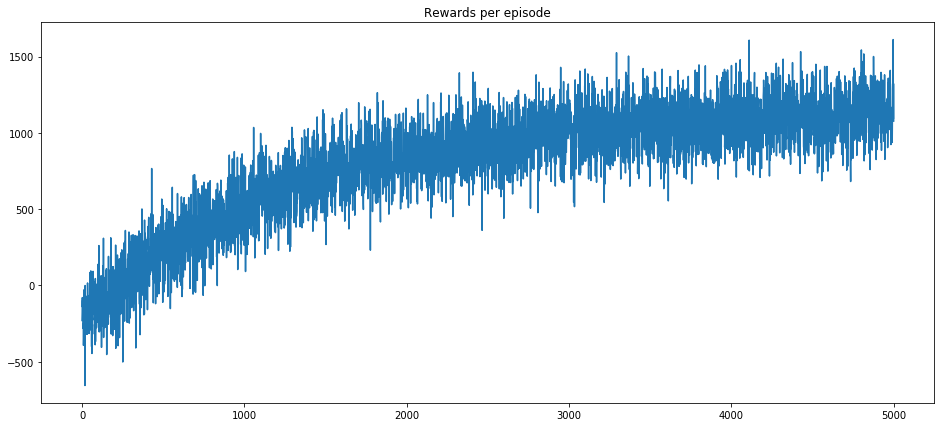

In [38]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)